# $Mantel$-$Rank:$ A Distance Correlation Framework for Rational Descriptor Selection in QSAR

Manas Mahale, Srijit Seal, Elvis Martis, Evans Coutinho, Andreas Bender

The Mantel test is a statistical method used to measure the correlation between two distance matrices. Our hypothesis is that an ideal molecular feature should conform to the **molecular similarity principle**: structurally similar compounds should exhibit similar biological activities(, and dissimilar compounds should have dissimilar activities). The Mantel test provides a direct and quantitative way to assess how well any given molecular feature aligns with this principle for a specific dataset.


### The Idea

The process involves creating two distinct types of distance matrices. The first, a **biological distance matrix**, is derived from the activity labels, where the distance between two compounds is zero if they have the same activity and one otherwise. The second type is a series of **chemical distance matrices**, with one matrix generated for each molecular descriptor or fingerprint. For descriptors, this distance is calculated using the Euclidean distance, while for fingerprints, the Tanimoto distance is used.

The Mantel test then calculates the Spearman correlation coefficient ($\rho$) between the biological distance matrix and each chemical distance matrix. A high, positive $r$ value signifies that the descriptor successfully separates compounds in a way that mirrors their activity differences, making it a strong candidate for model building. This process serves as a model-agnostic filter, creating an inductive bias towards features that are fundamentally aligned with the structure-activity relationship of the data.

#### ENV stuff

In [1]:
!conda env export -n mantelrank_env -f environment.yaml

name: mantelrank_env
channels:
  - conda-forge
  - defaults
dependencies:
  - bzip2=1.0.8=h99b78c6_7
  - ca-certificates=2025.8.3=hbd8a1cb_0
  - icu=75.1=hfee45f7_0
  - libexpat=2.7.1=hec049ff_0
  - libffi=3.4.6=h1da3d7d_1
  - liblzma=5.8.1=h39f12f2_2
  - libsqlite=3.50.4=h4237e3c_0
  - libzlib=1.3.1=h8359307_2
  - ncurses=6.5=h5e97a16_3
  - openssl=3.5.2=he92f556_0
  - pip=25.2=pyh8b19718_0
  - python=3.11.13=hc22306f_0_cpython
  - readline=8.2=h1d1bf99_2
  - setuptools=80.9.0=pyhff2d567_0
  - tk=8.6.13=h892fb3f_2
  - wheel=0.45.1=pyhd8ed1ab_1
  - pip:
      - anyio==4.10.0
      - appnope==0.1.4
      - argon2-cffi==25.1.0
      - argon2-cffi-bindings==25.1.0
      - arrow==1.3.0
      - asttokens==3.0.0
      - async-lru==2.0.5
      - attrs==25.3.0
      - babel==2.17.0
      - beautifulsoup4==4.13.4
      - bleach==6.2.0
      - certifi==2025.8.3
      - cffi==1.17.1
      - charset-normalizer==3.4.3
      - comm==0.2.3
      - contourpy==1.3.3
      - cycler==0.12.1
      - debug

In [2]:
!tree .

.
├── Combined_DILI_Labels__preview_.csv
├── DILI_Goldstandard_1111_std.csv
├── DILI_Goldstandard_1111.csv
├── environment.yaml
├── MantelRank.ipynb
├── test_df.pkl
└── train_df.pkl

0 directories, 7 files


In [3]:
import os
import math
import time
import pickle
import requests
from urllib.parse import quote
import molvs
import mantel
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, rdFingerprintGenerator, MACCSkeys, DataStructs, Draw

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    matthews_corrcoef,
    recall_score,
    roc_curve,
    auc,
    classification_report,
    precision_recall_curve,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    matthews_corrcoef
) 
from pauc.roc_auc_ci import delong_roc_test
from pauc import plot_roc_with_ci

In [5]:
RDLogger.DisableLog("rdApp.*")

## Data

Seal, S., Williams, D., Hosseini-Gerami, L., Mahale, M., Carpenter, A.E., Spjuth, O., Bender, A., 2024. Improved Detection of Drug-Induced Liver Injury by Integrating Predicted In Vivo and In Vitro Data. Chem. Res. Toxicol. 37, 1290–1305. https://doi.org/10.1021/acs.chemrestox.4c00015


### Note on Standardization of SMILES
Standardization is based on checking if the input SMILES (in the dataset) is valid, and then disconnecting the metal(/s), Choosing the largest organic fragment (here, organic means the fragment which has at least one carbon), un-charging the molecule and finally checking if the molecule is valid only then to chose the canonical tautomer. This molecule then, if valid, is converted into canonical SMILES and returned as a string. If there is any error in this process, None is returned.

In [6]:
md = molvs.metal.MetalDisconnector()
lfc = molvs.fragment.LargestFragmentChooser()
uc = molvs.charge.Uncharger()

In [7]:
def standardize_smiles(smiles):
    try:
        std_smiles = molvs.standardize.standardize_smiles(smiles)
        std_mol = Chem.MolFromSmiles(std_smiles)
        std_mol = md.disconnect(std_mol)
        std_mol = lfc.choose(std_mol)
        std_mol = uc.uncharge(std_mol)
        std_smi = Chem.MolToSmiles(std_mol)
        if not molvs.validate.validate_smiles(std_smi):
            std_smi = molvs.standardize.canonicalize_tautomer_smiles(std_smi)
            return std_smi
    except:
        return None

In [8]:
if not os.path.exists("DILI_Goldstandard_1111_std.csv"):
    df = pd.read_csv("./DILI_Goldstandard_1111.csv")
    df["standardized_smiles"] = df["smiles_r"].apply(standardize_smiles)
    df.dropna(subset=["standardized_smiles"], inplace=True)
    df.drop_duplicates(subset=["standardized_smiles"], inplace=True)
    df.to_csv('DILI_Goldstandard_1111_std.csv', index=False)
df = pd.read_csv('DILI_Goldstandard_1111_std.csv')

<Axes: ylabel='Frequency'>

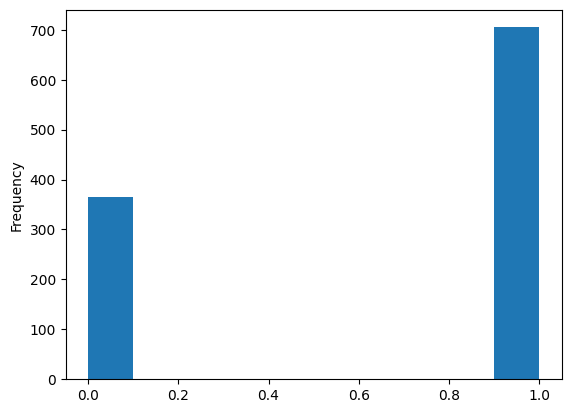

In [9]:
df['TOXICITY'].plot.hist()

## Methodology:

Let $M = \{m_1, m_2, ..., m_n\}$ be a set of $n$ molecules, and let $A = \{a_1, a_2, ..., a_n\}$ be the corresponding vector of binary activity labels, where $a_i \in \{0, 1\}$. (Activity labels can also be continuous, in this case, DILI prediction, we use categorical labels).

1.  **Activity Dissimilarity Matrix ($D_{Bio}$):**
    The dissimilarity in the activity space is computed as the pairwise absolute difference in activity labels. The resulting $n \times n$ symmetric matrix $D_{Bio}$ has elements:
    $$D_{A_{ij}} = |a_i - a_j|$$
    The elements of $D_{Bio}$ will be either 0 (same activity) or 1 (different activity).

2.  **Chemical Dissimilarity Matrices ($D_X$):**
    For each feature set $X$ (where $X$ can be a single RDKit descriptor, a set of descriptors, or a type of fingerprint), an $n \times n$ chemical dissimilarity matrix $D_X$ is computed.

    * **For scalar descriptors (e.g., LogP, TPSA):** The feature space is a vector of $n$ values. Dissimilarity is the pairwise Euclidean distance:
        $$D_{X_{ij}} = \sqrt{(x_i - x_j)^2}$$
      
    * **For fingerprints (e.g., ECFP4, MACCS):** The feature space consists of binary vectors. Dissimilarity is the Tanimoto distance:
        $$D_{X_{ij}} = 1 - T_c(f_i, f_j) = 1 - \frac{|f_i \cap f_j|}{|f_i \cup f_j|}$$
        where $f_i$ and $f_j$ are the fingerprint vectors for molecules $m_i$ and $m_j$.

4.  **Correlation Analysis (Mantel Test):**
    The Mantel test is used to compute the Spearman correlation coefficient, $\rho$, between the activity dissimilarity matrix $D_{Bio}$ and each chemical dissimilarity matrix $D_X$.
    $$\rho(D_{Bio}, D_X)$$
    A permutation test is performed to assess the statistical significance of this correlation, yielding a p-value.

5.  **Ranking and Selection:**
    All computed feature sets (descriptors and fingerprints) are ranked based on their Mantel correlation coefficient $r$ (higher is better) and associated $p$-value (lower is better).

In [10]:
ecfp4gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
atomgen = rdFingerprintGenerator.GetAtomPairGenerator()

In [11]:
df['ECFP4'] = df['standardized_smiles'].apply(lambda m: ecfp4gen.GetFingerprint(Chem.MolFromSmiles(m)))
df['AtomPairs'] = df['standardized_smiles'].apply(lambda m: atomgen.GetFingerprint(Chem.MolFromSmiles(m)))
df['MACCS'] = df['standardized_smiles'].apply(lambda m: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(m)))
df = df.join(pd.DataFrame([Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(s)) for s in df['standardized_smiles']], index=df.index))

### Check for NaN in Descriptors / Weird Molecules

In [12]:
bad_smis = df[df.isna().any(axis=1)]['smiles_r'].values
df[df.isna().any(axis=1)]

smiles_r  TOXICITY  Source_rank  \
591                     CC(=O)Nc1cc([As](=O)(O)O)ccc1O         1            1   
817  O=[P-](=O)(O)C([S+]=C1C=CC(=[Cl+])C=C1)[P-](=O...         0            1   

                             Source  Data                     InChIKey  \
591  DILIst Classification  Vaginal  DILI  ODFJOVXVLFUVNQ-UHFFFAOYSA-N   
817     DILIst Classification  Oral  DILI  YJPVNWRCJRDXEZ-UHFFFAOYSA-N   

         InChIKey14                                protonated_smiles_r  \
591  ODFJOVXVLFUVNQ                     CC(=O)Nc1cc([As](=O)(O)O)ccc1O   
817  YJPVNWRCJRDXEZ  O=[P-](=O)(O)C([S+]=C1C=CC(=[Cl+])C=C1)[P-](=O...   

                                   standardized_smiles  \
591                     CC(=O)Nc1cc([As](=O)(O)O)ccc1O   
817  O=[P-](=O)(O)C([S+]=C1C=CC(=[Cl+])C=C1)[P-](=O...   

                                                 ECFP4  ... fr_sulfide  \
591  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ...          0   
817  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ...          0   

    fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
591            0           0                  0             0            0   
817            0           0                  0             0            0   

     fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
591            0             0                 0        0  
817            0             0                 0        0  

[2 rows x 229 columns]

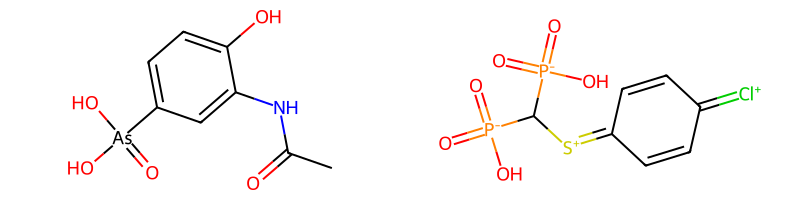

In [13]:
mols = [Chem.MolFromSmiles(i) for i in bad_smis]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 200))

These two are really weird molecules, so, for all the obvious reasons, so I'm going to remove them from the dataset

In [14]:
df.dropna(inplace=True)

In [15]:
df.shape

(1069, 229)

## Held Out Test Set

In [16]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [17]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

In [18]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

#### $D_{Bio}:$ Biological Difference Matrix

In [19]:
D_Bio = np.abs(train_df['TOXICITY'].values - train_df['TOXICITY'].values.reshape(-1, 1))

<Axes: >

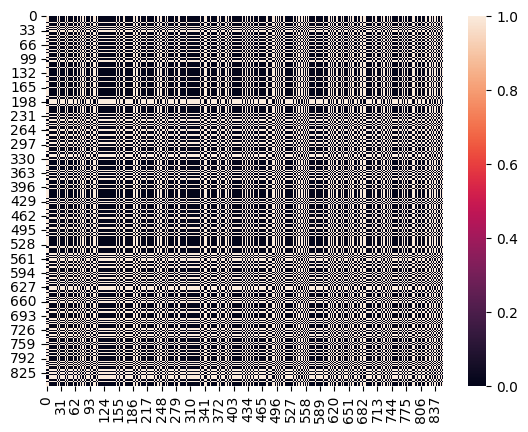

In [20]:
sns.heatmap(D_Bio)

#### $D_X:$ Descriptor / Fingerprint Similarity

In [21]:
DXs = {}

In [22]:
D_X_ecfp4 = np.zeros((train_df.shape[0], train_df.shape[0]))

for n, i in enumerate(train_df['ECFP4'].tolist()):
    D_X_ecfp4[n] = DataStructs.BulkTanimotoSimilarity(i, train_df['ECFP4'].tolist())

DXs['ECFP4'] = 1 - D_X_ecfp4

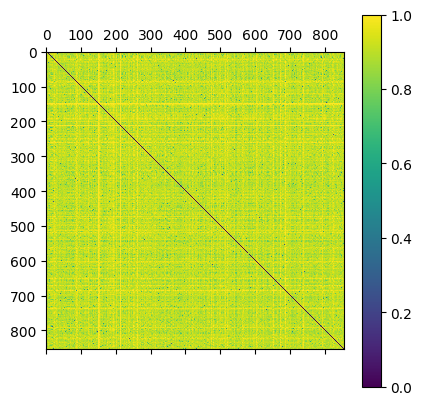

In [23]:
plt.matshow(DXs['ECFP4'])
plt.colorbar()

In [24]:
D_X_atomp = np.zeros((train_df.shape[0], train_df.shape[0]))

for n, i in enumerate(train_df['AtomPairs'].tolist()):
    D_X_atomp[n] = DataStructs.BulkTanimotoSimilarity(i, train_df['AtomPairs'].tolist())

DXs['AtomPairs'] = 1 - D_X_atomp

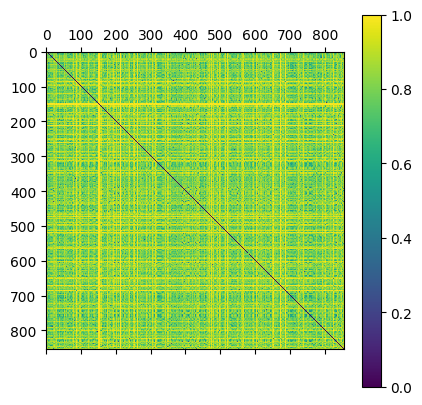

In [25]:
plt.matshow(DXs['AtomPairs'])
plt.colorbar()

In [26]:
D_X_maccs = np.zeros((train_df.shape[0], train_df.shape[0]))

for n, i in enumerate(train_df['MACCS'].tolist()):
    D_X_maccs[n] = DataStructs.BulkTanimotoSimilarity(i, train_df['MACCS'].tolist())

DXs['MACCS'] = 1 - D_X_ecfp4

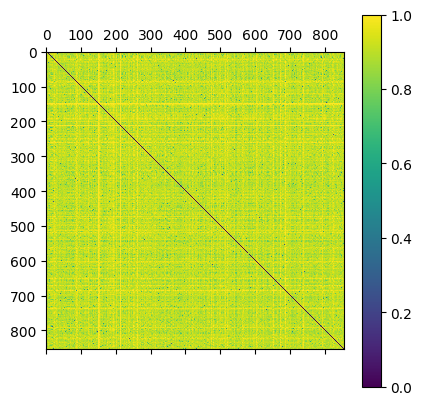

In [27]:
plt.matshow(DXs['MACCS'])
plt.colorbar()

In [28]:
def euclidean_distance(points_array):
    points_array = np.asarray(points_array)
    n_points = points_array.shape[0]
    sum_sq = np.sum(points_array**2, axis=1, keepdims=True)
    dot_product = -2 * np.dot(points_array, points_array.T)
    # (a^2 + b^2 - 2ab)
    squared_distances = sum_sq + sum_sq.T + dot_product
    squared_distances[squared_distances < 0] = 0
    distance_matrix = np.sqrt(squared_distances)
    np.fill_diagonal(distance_matrix, 0)
    assert (distance_matrix == distance_matrix.T).all(), "FLOATING POINT ERROR"
    return distance_matrix

In [29]:
for i in tqdm(train_df.columns[12:]):
    dist = euclidean_distance(train_df[[i]].values)
    DXs[i] = dist

100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 275.63it/s]


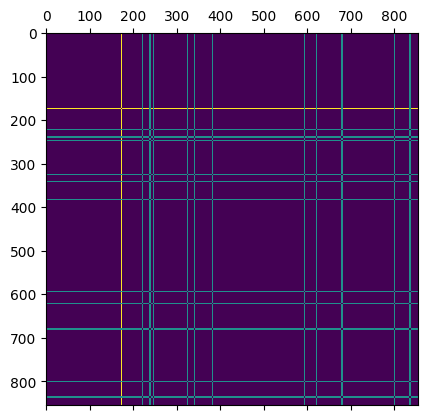

In [30]:
plt.matshow(DXs[i])

In [31]:
len(DXs.keys())

220

We now have 220 Structural Fingerprint / Descriptor Distance Matrices ready.

## Mantel Test

In [32]:
mantel_results = {} 

for desc_name, D_X in tqdm(DXs.items()):
    try:
        mantel_results[desc_name] = mantel.test(D_X, D_Bio, perms=10000, method='spearman', tail='upper')
    except:
        mantel_results[desc_name] = None

 33%|██████████████████████████▏                                                     | 72/220 [18:08<39:14, 15.91s/it]/Users/manasmahale/miniconda3/envs/mantelrank_env/lib/python3.11/site-packages/mantel/_test.py:300: RuntimeWarning: invalid value encountered in divide
  return covariances / denominator
/Users/manasmahale/miniconda3/envs/mantelrank_env/lib/python3.11/site-packages/mantel/_test.py:245: RuntimeWarning: invalid value encountered in scalar divide
  correlations[0] = sum(X_residuals[finite_Y] * Y_residuals[finite_Y]) / np.sqrt(
100%|███████████████████████████████████████████████████████████████████████████████| 220/220 [58:59<00:00, 16.09s/it]


In [33]:
with open('mantel_results.pickle', 'wb') as f:
    pickle.dump(mantel_results, f, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('mantel_results.pickle', 'rb') as f:
    mantel_results = pickle.load(f)

In [35]:
df_mantel_results = pd.DataFrame(mantel_results).T
df_mantel_results.columns = ["Mantel r", "p-value", "z-score"]
df_mantel_results.to_csv("mantel_results.csv")

In [36]:
for i in df_mantel_results[df_mantel_results.isnull().any(axis=1)].index:
    mantel_results.pop(i, None)

In [37]:
!mkdir mantel_plots

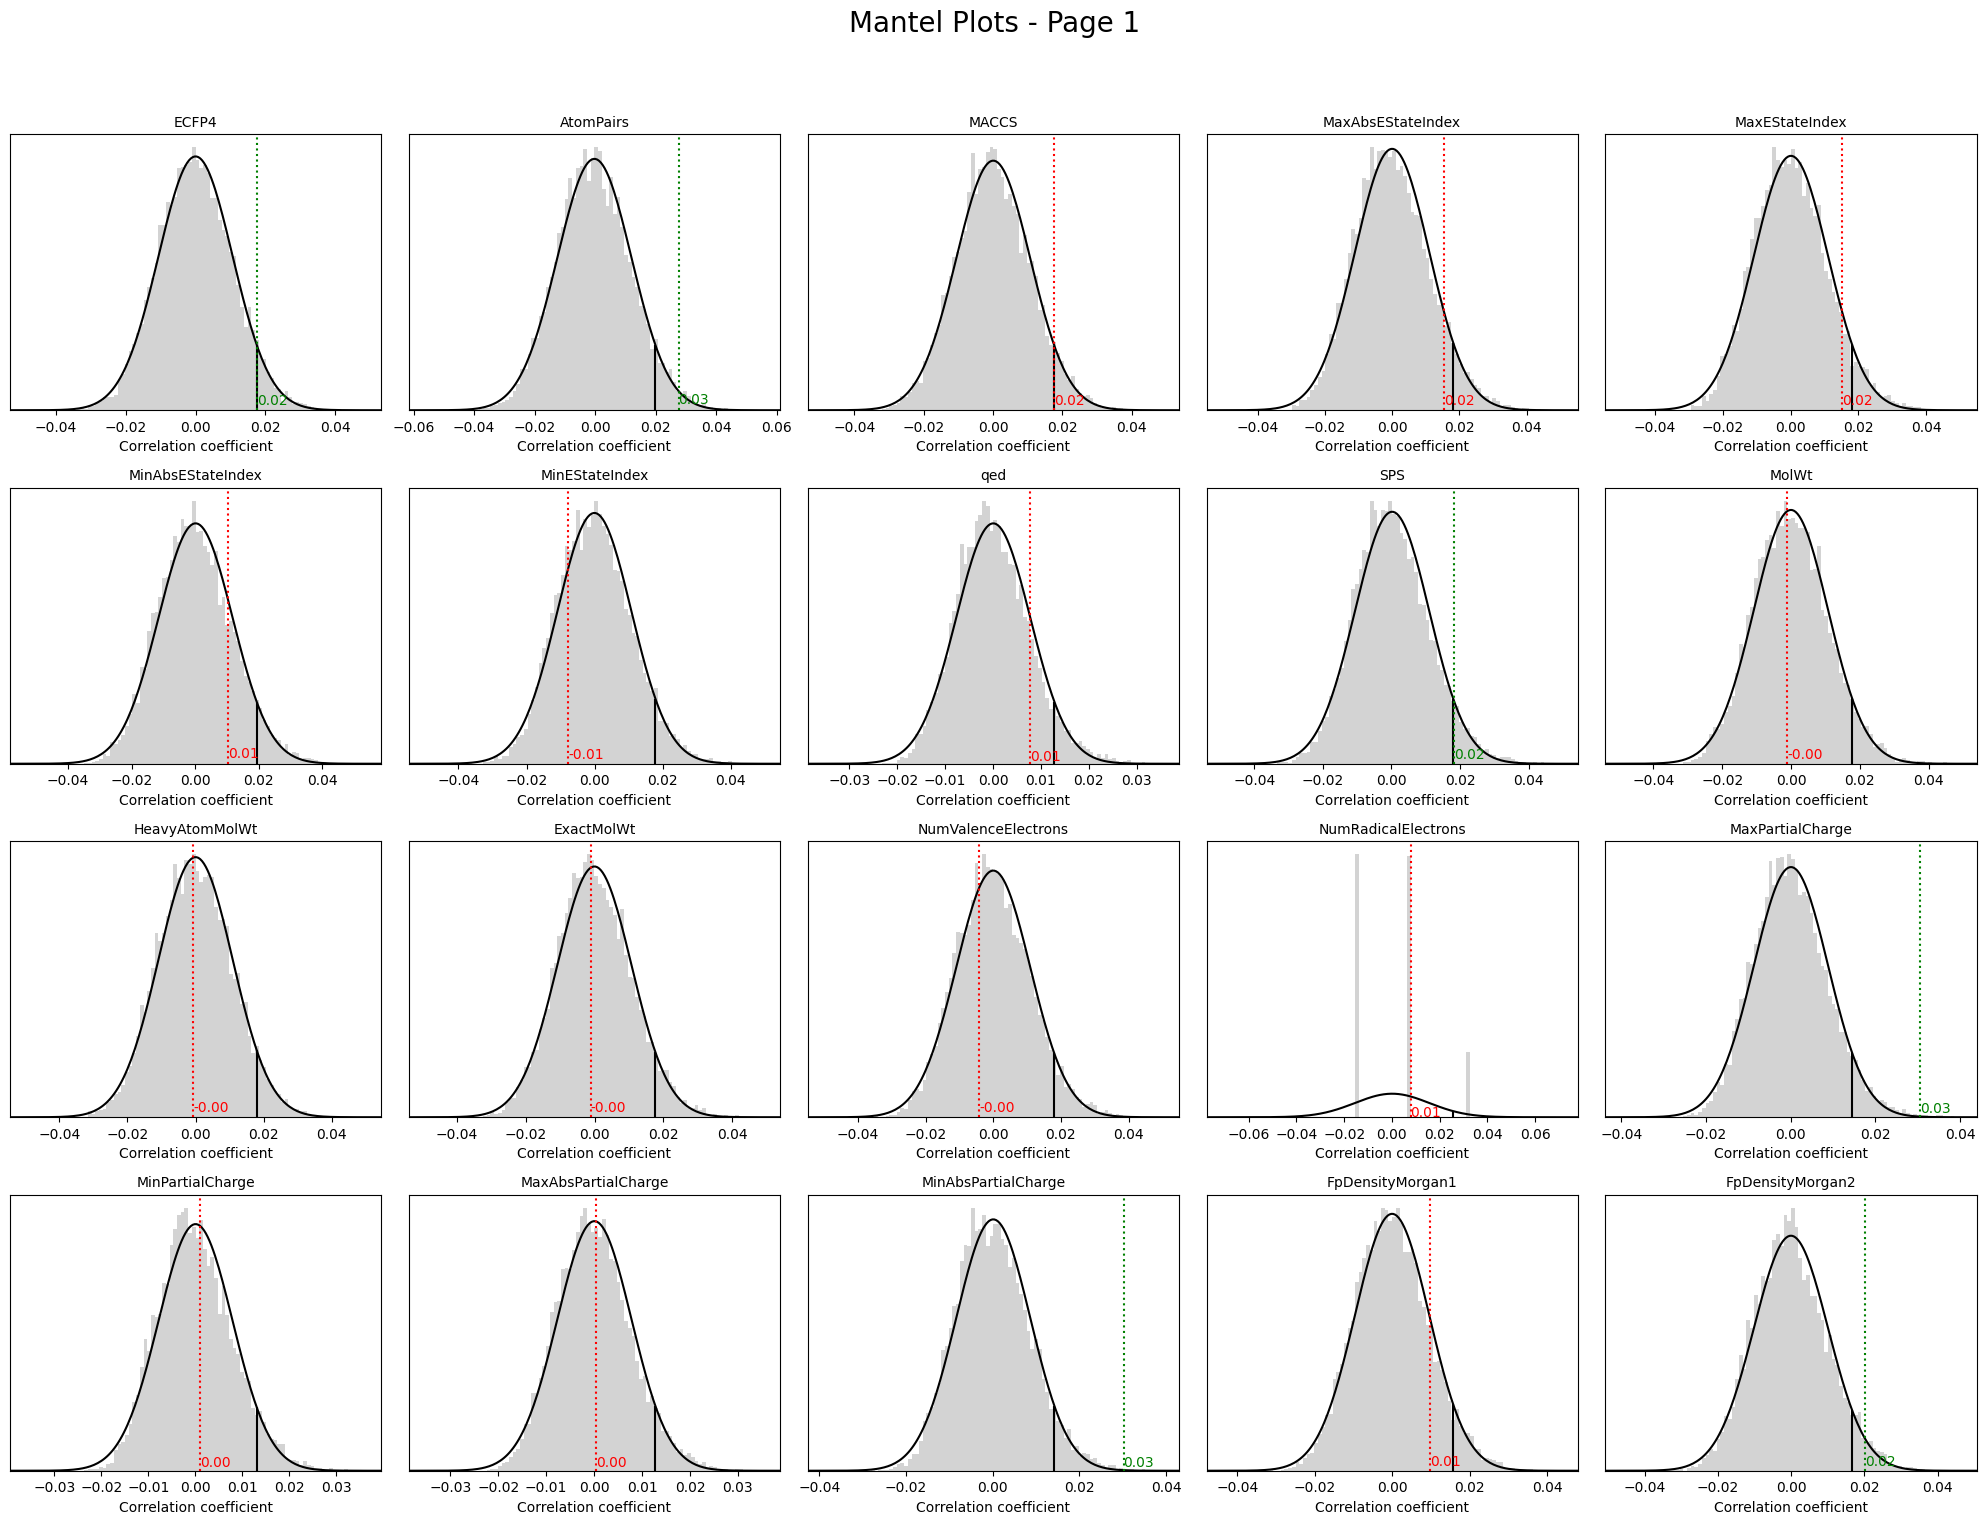

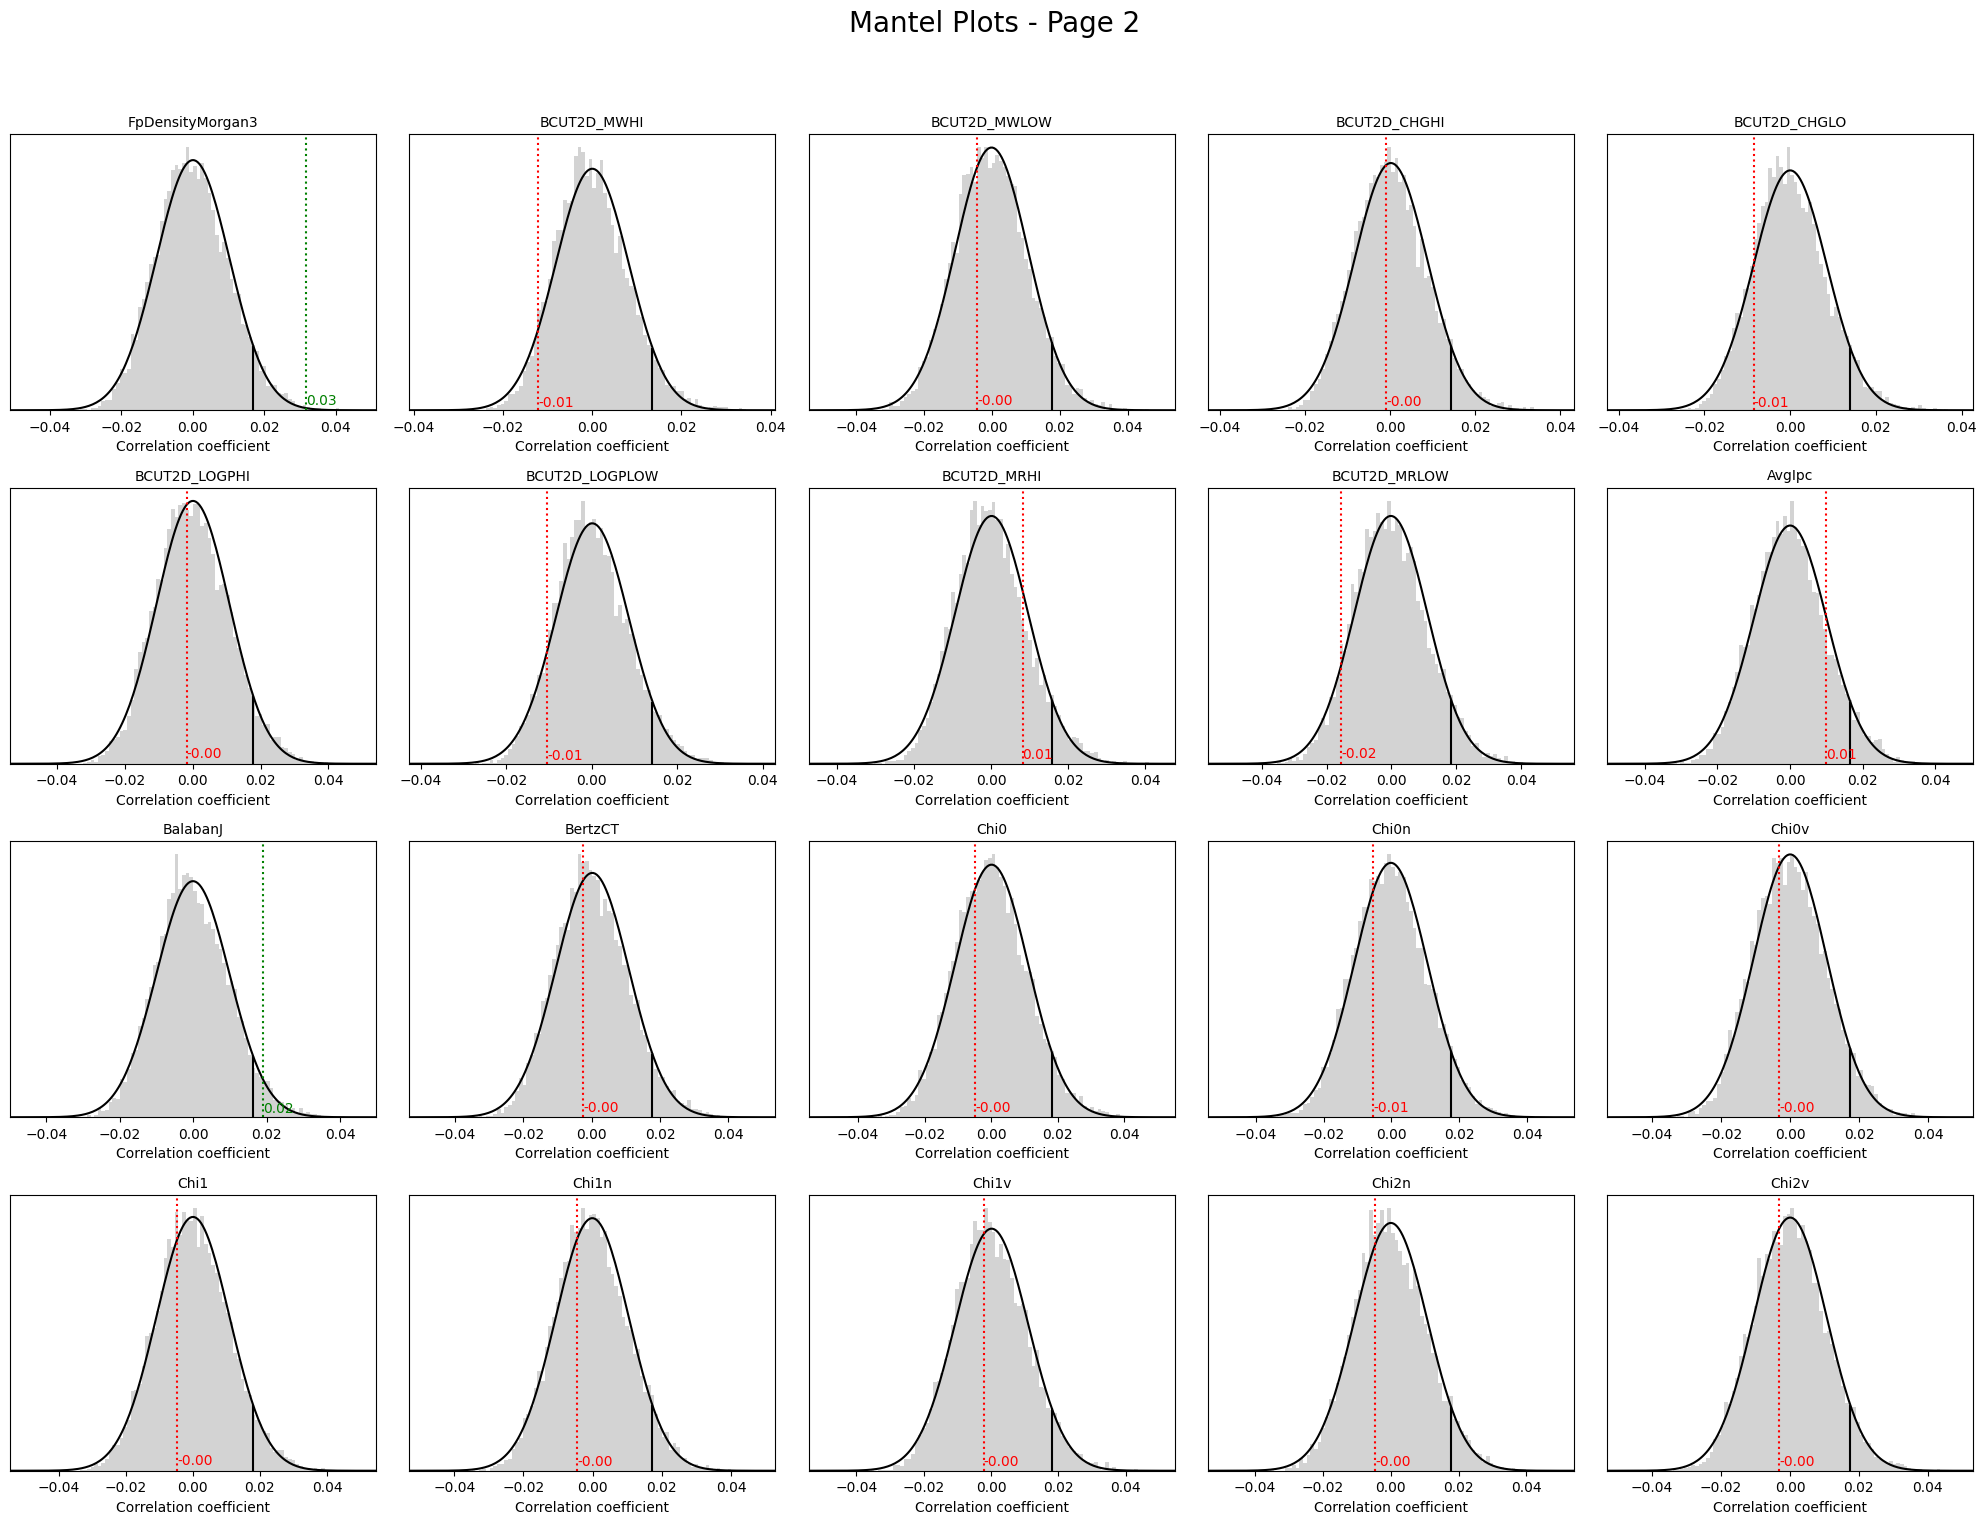

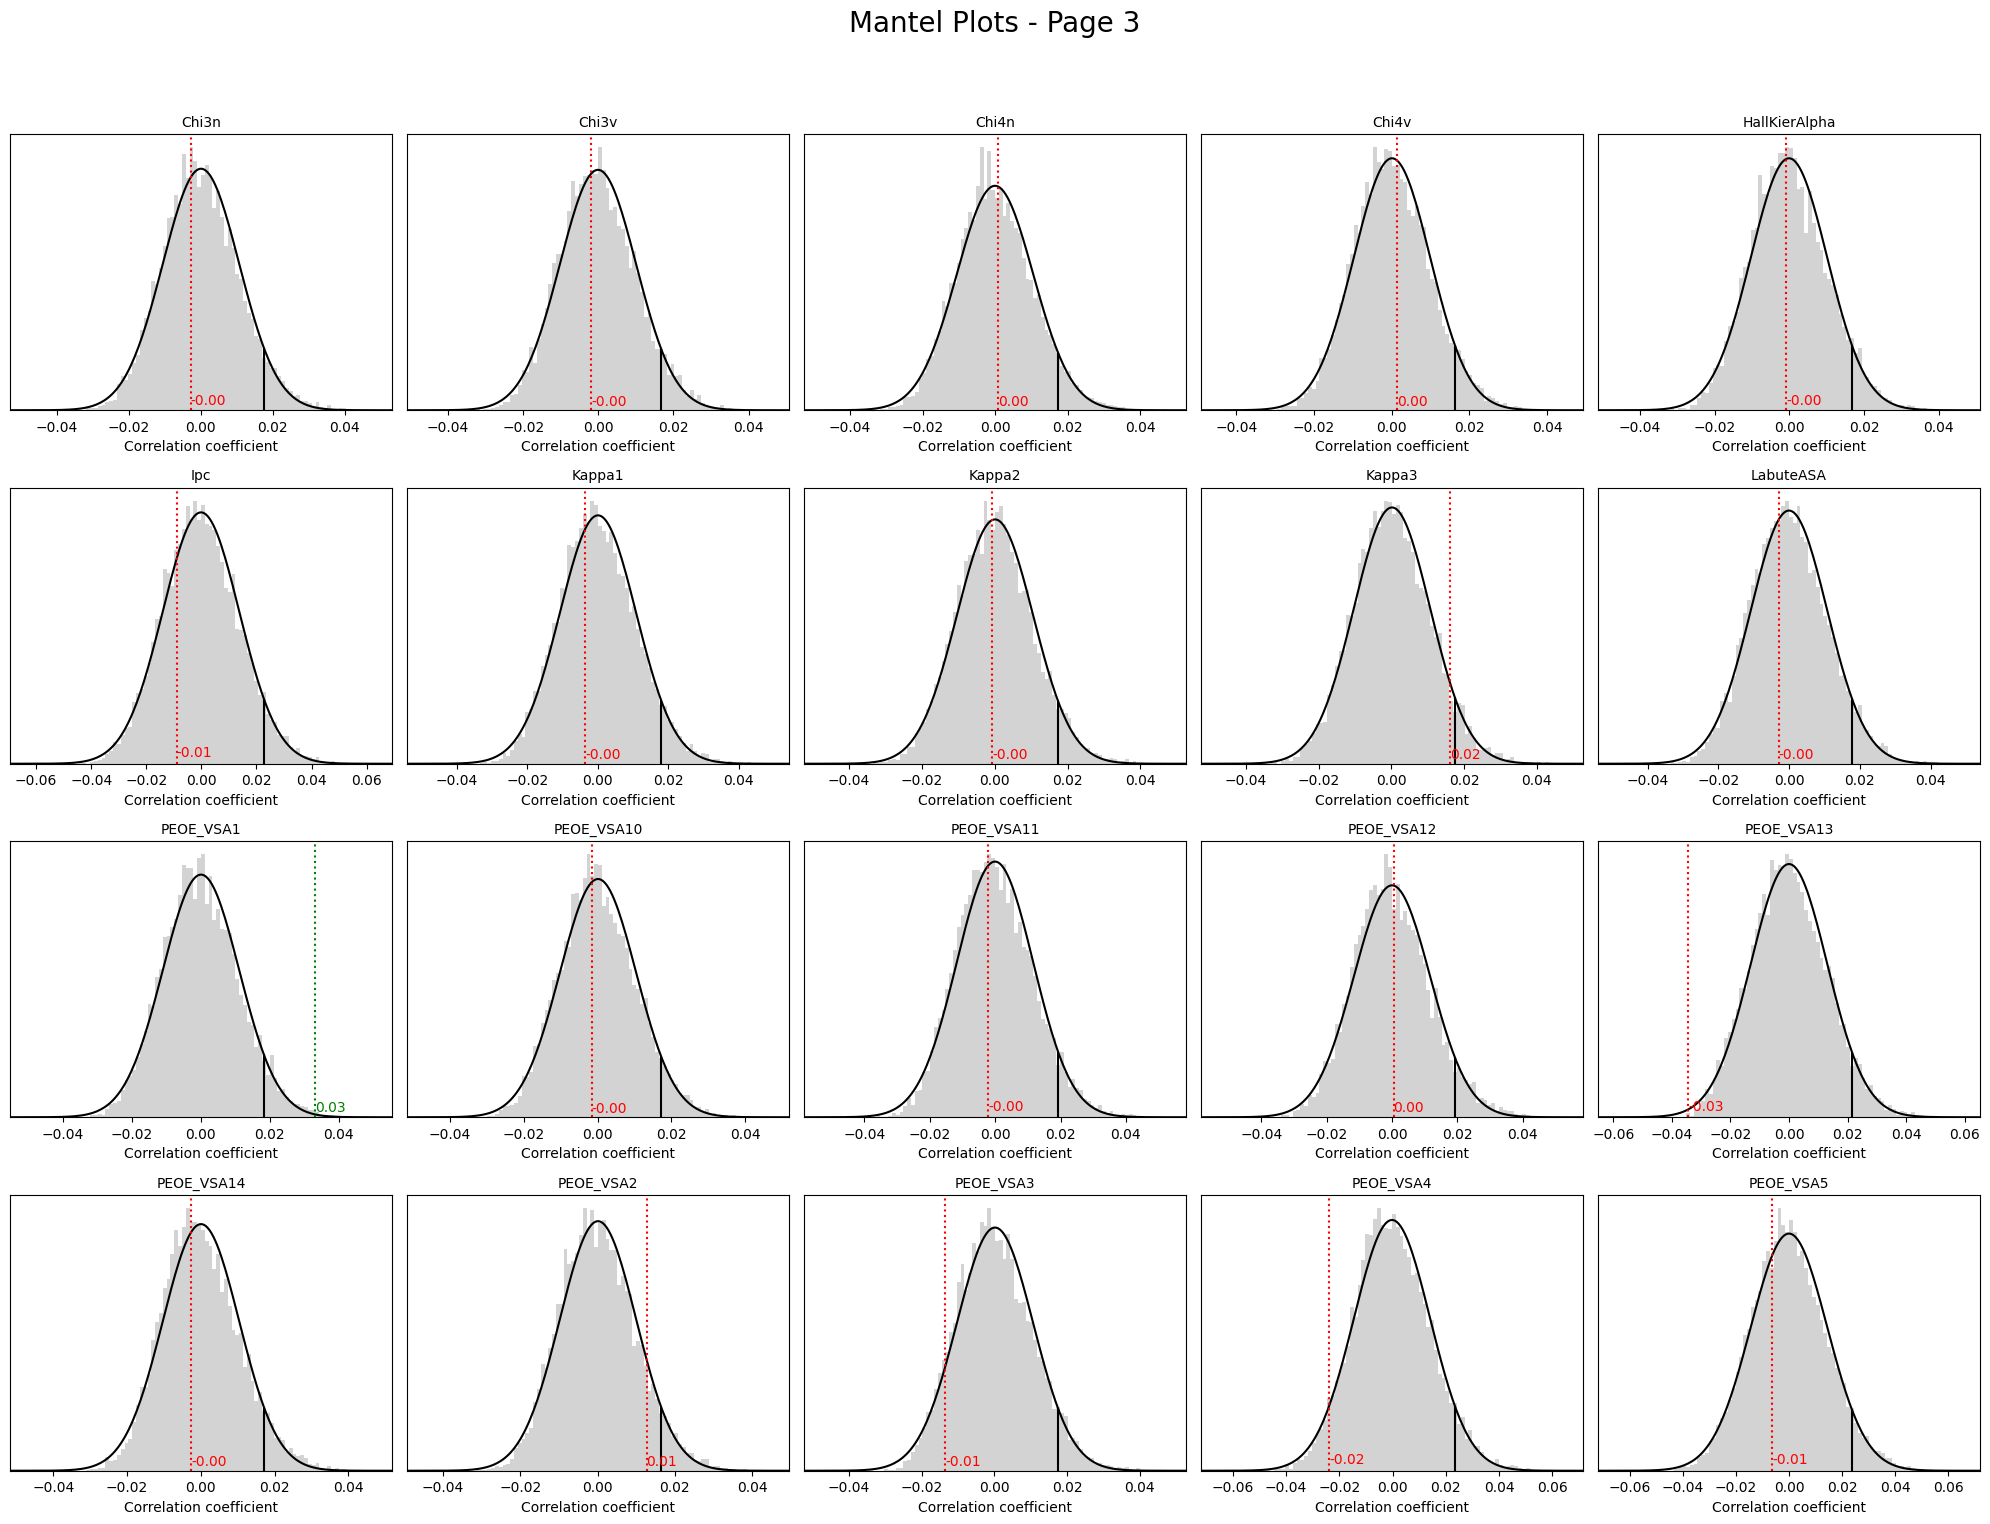

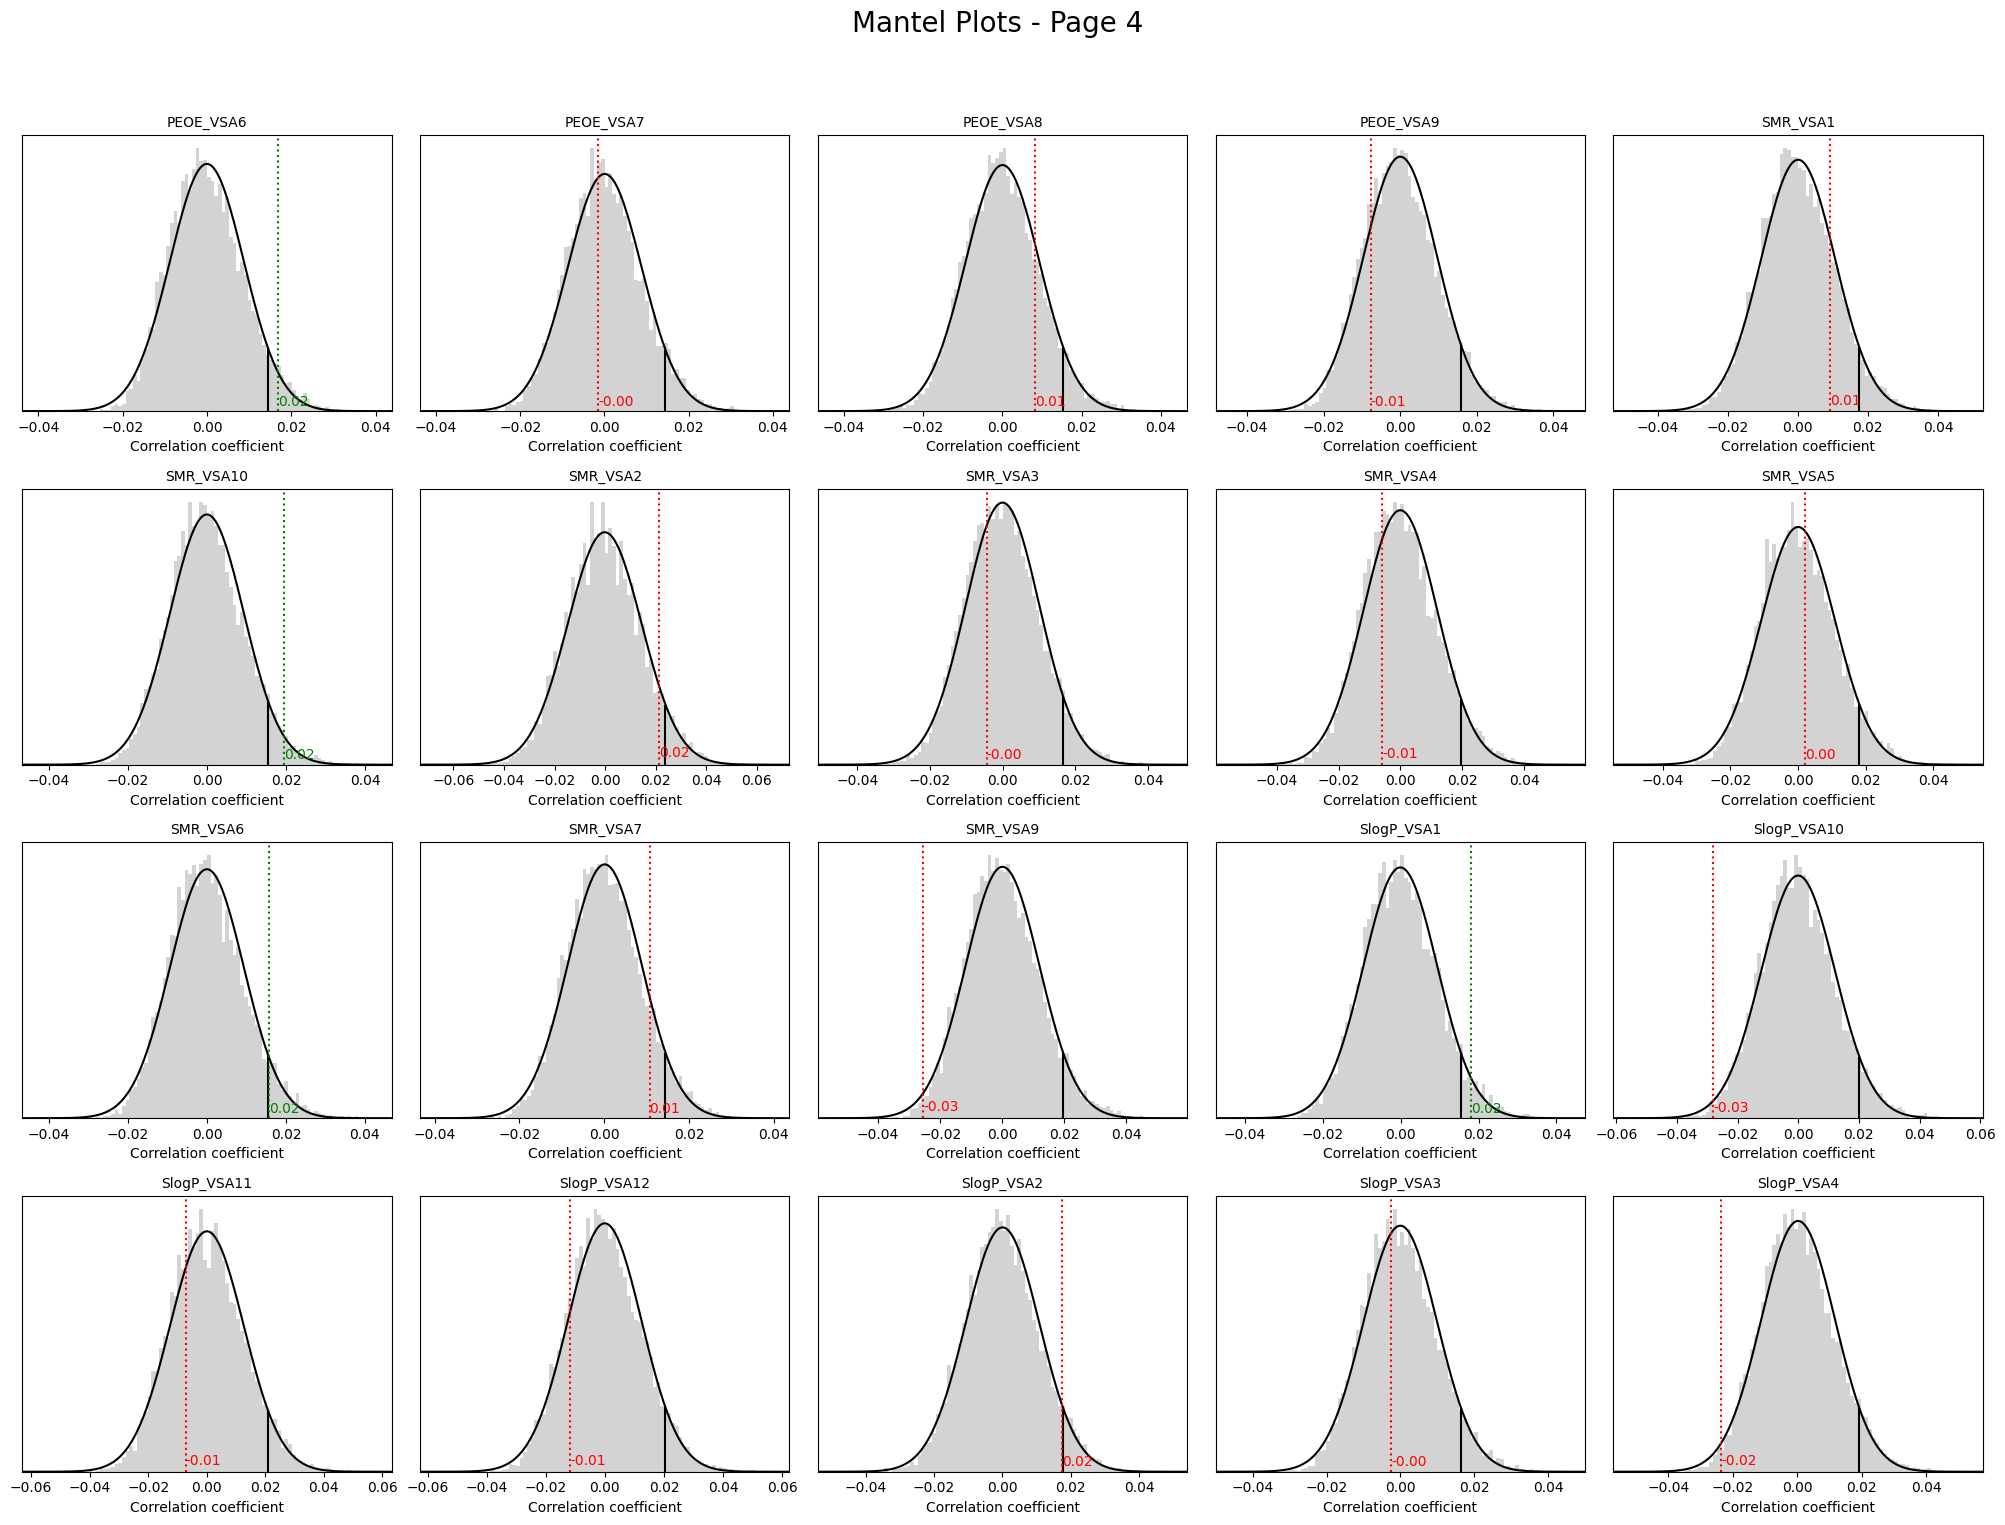

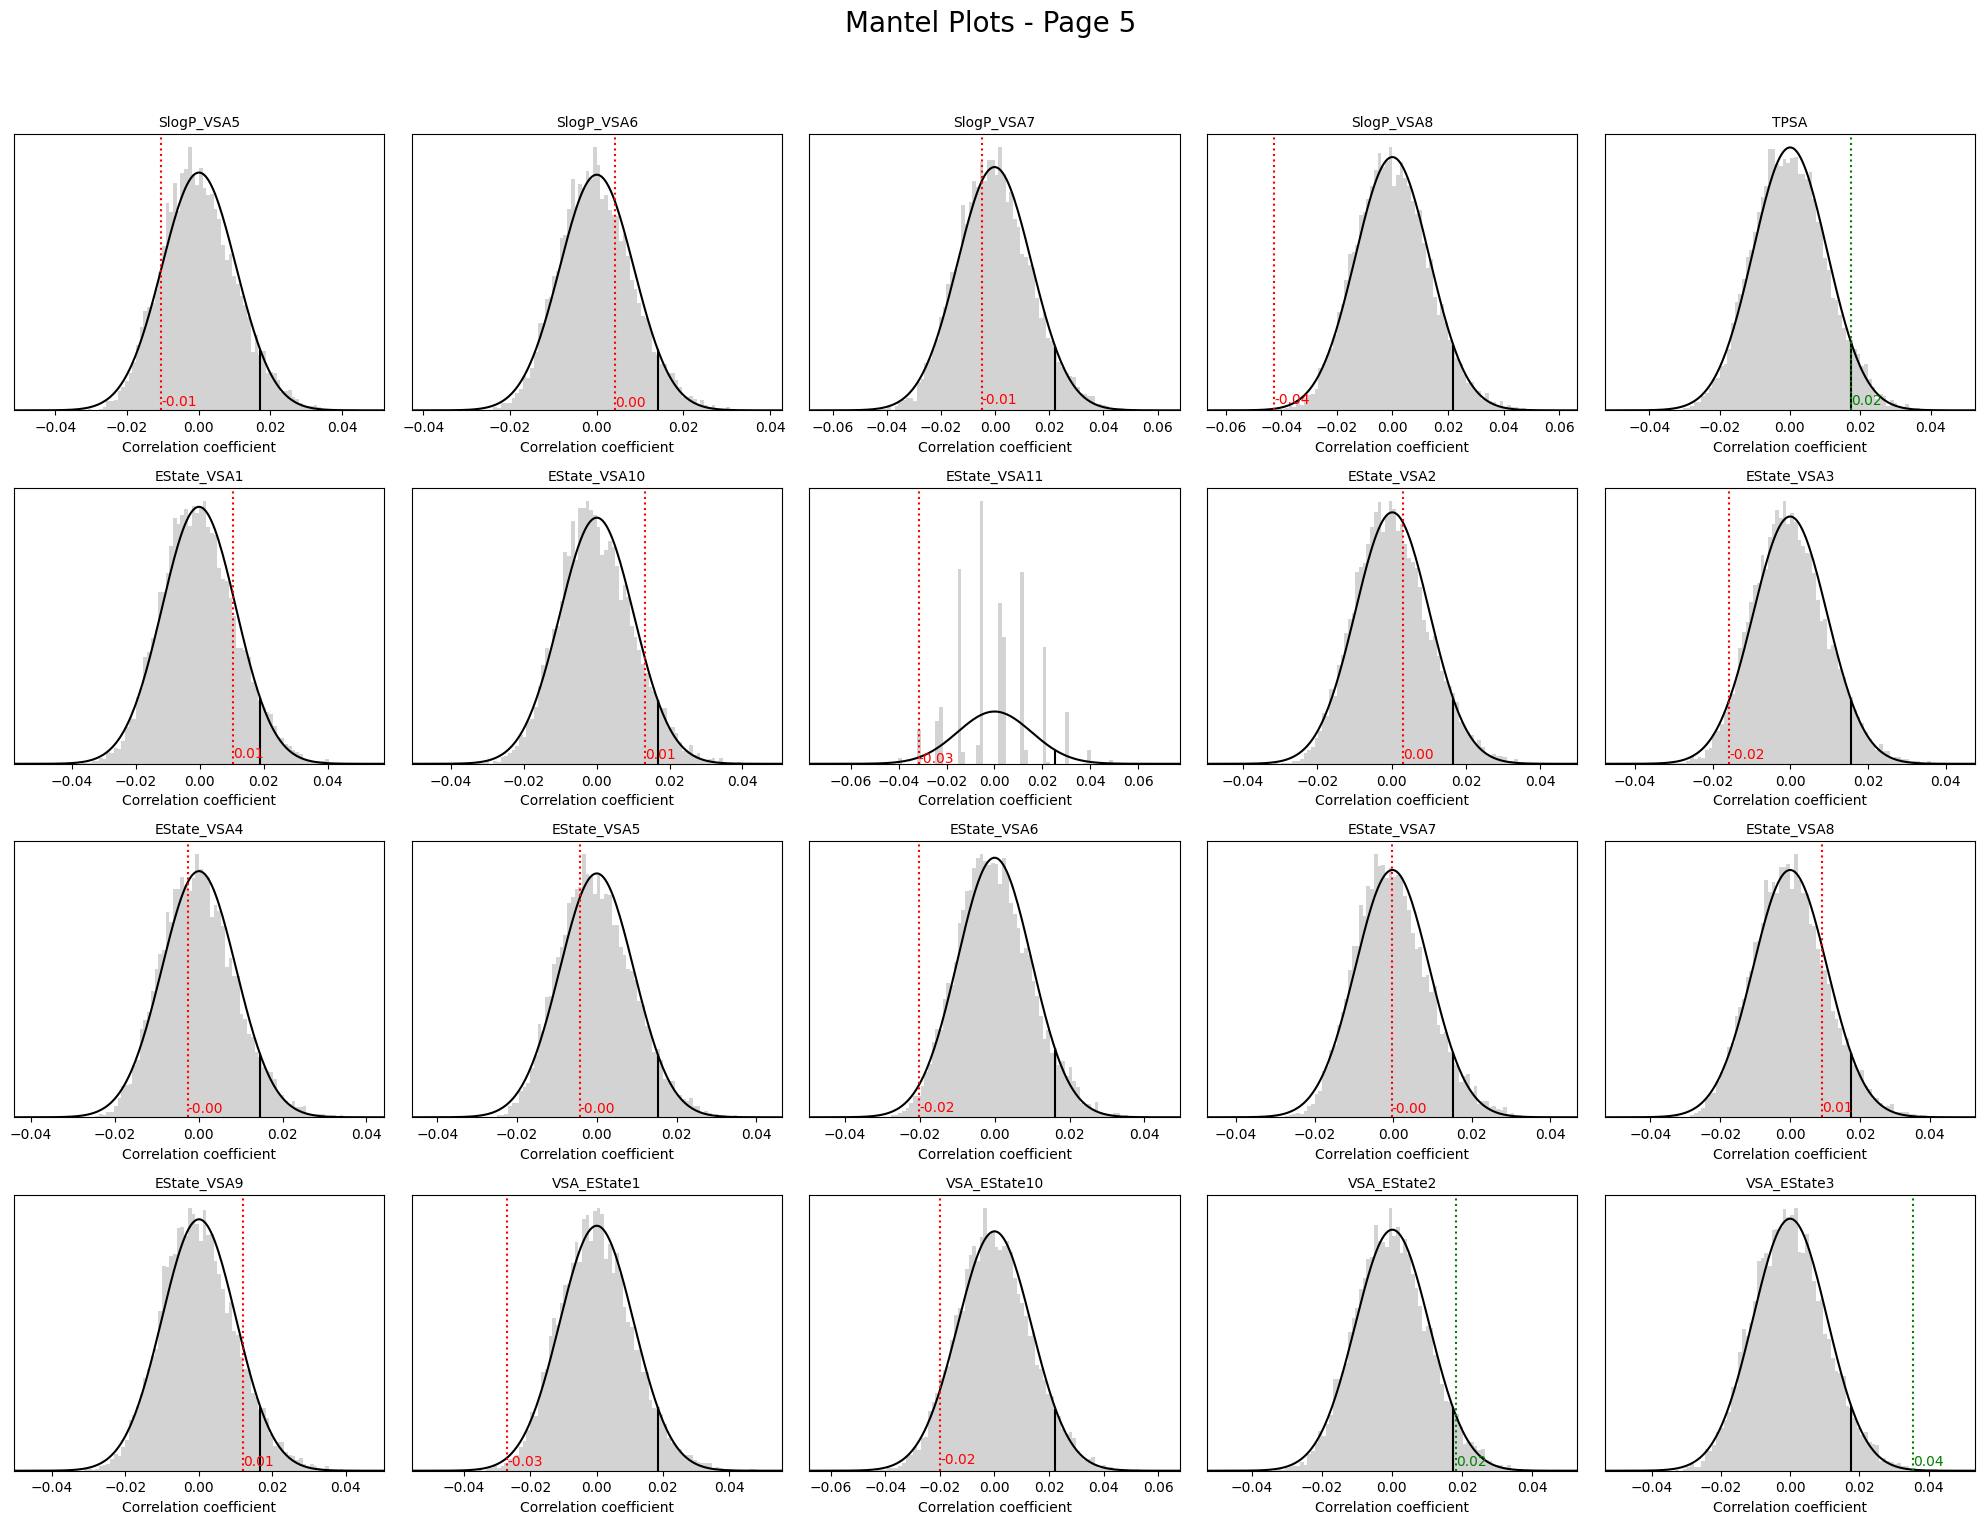

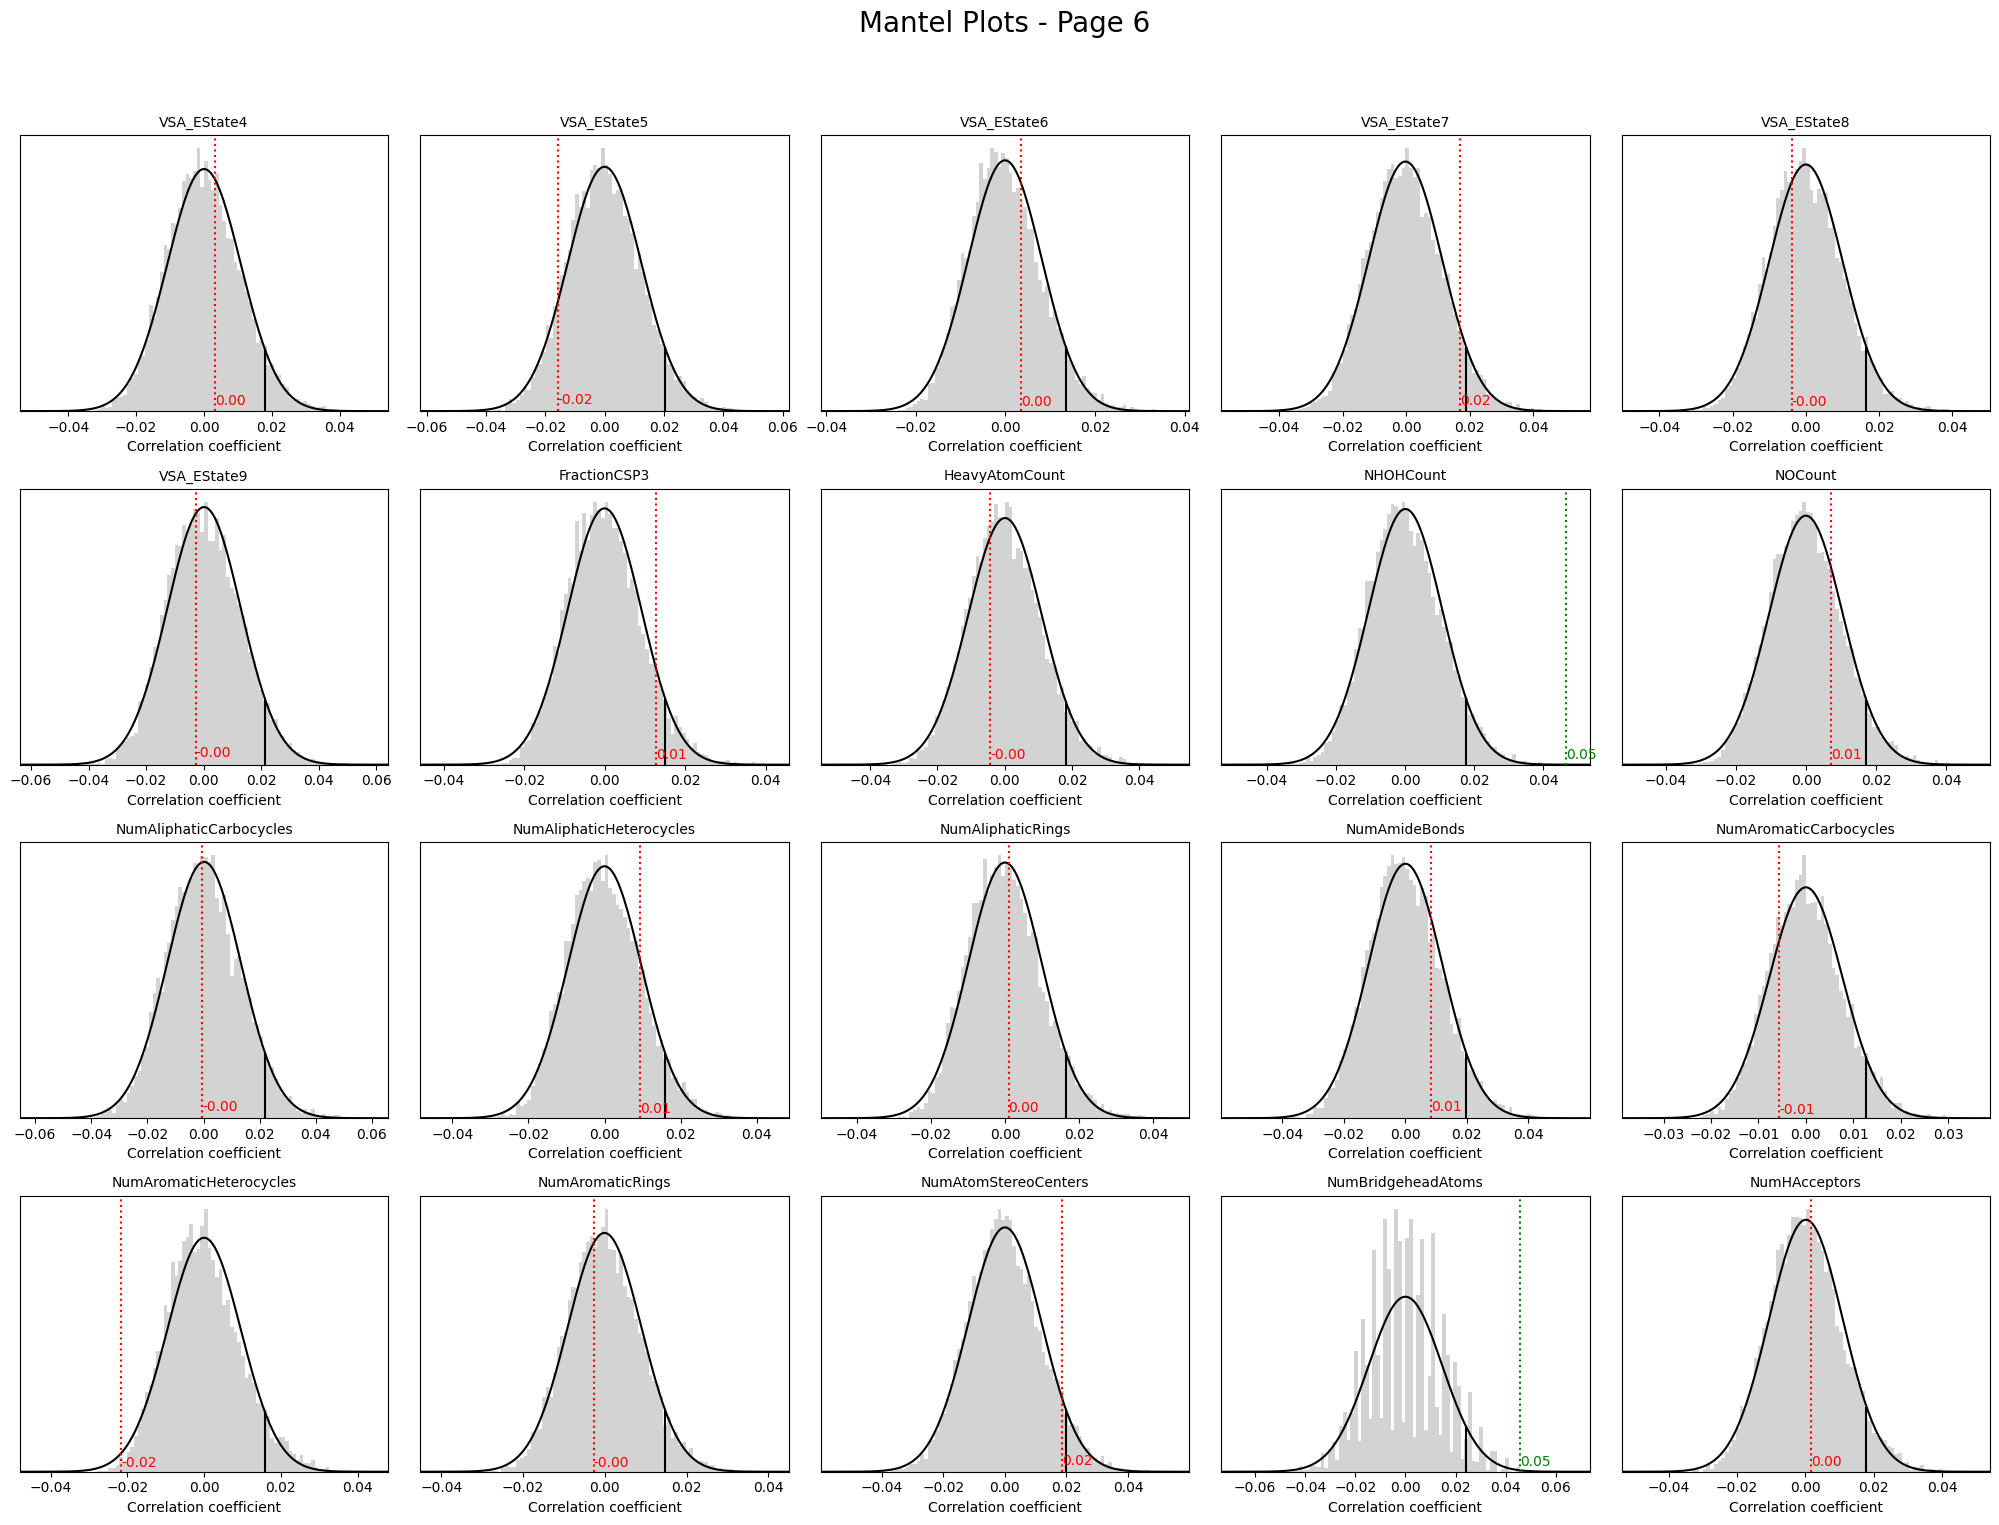

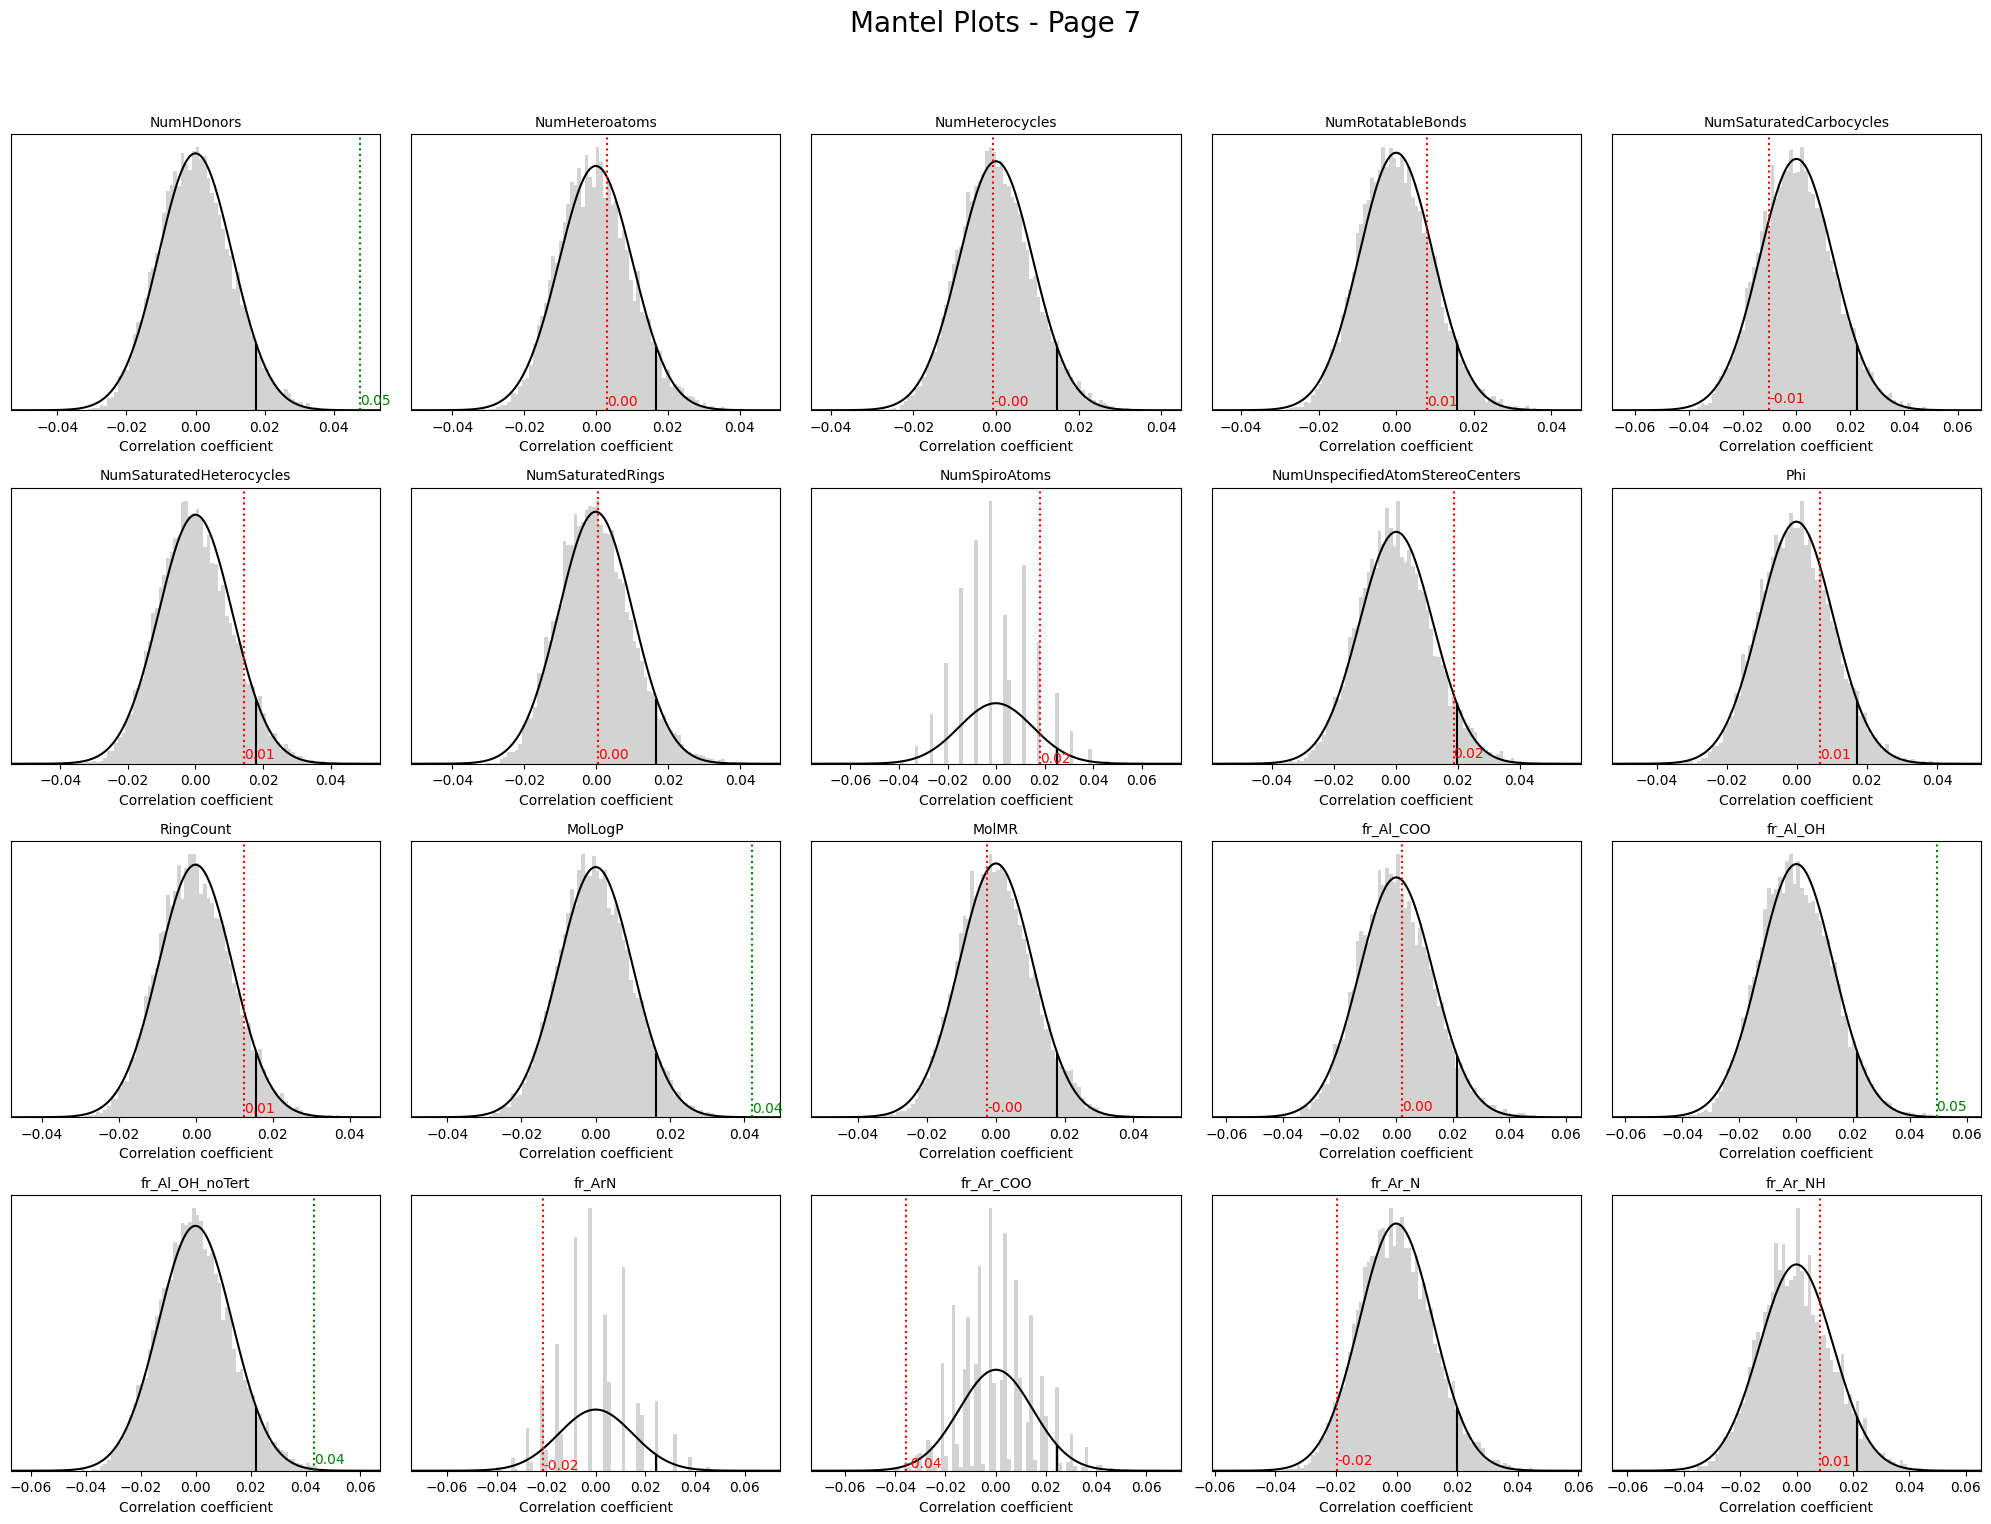

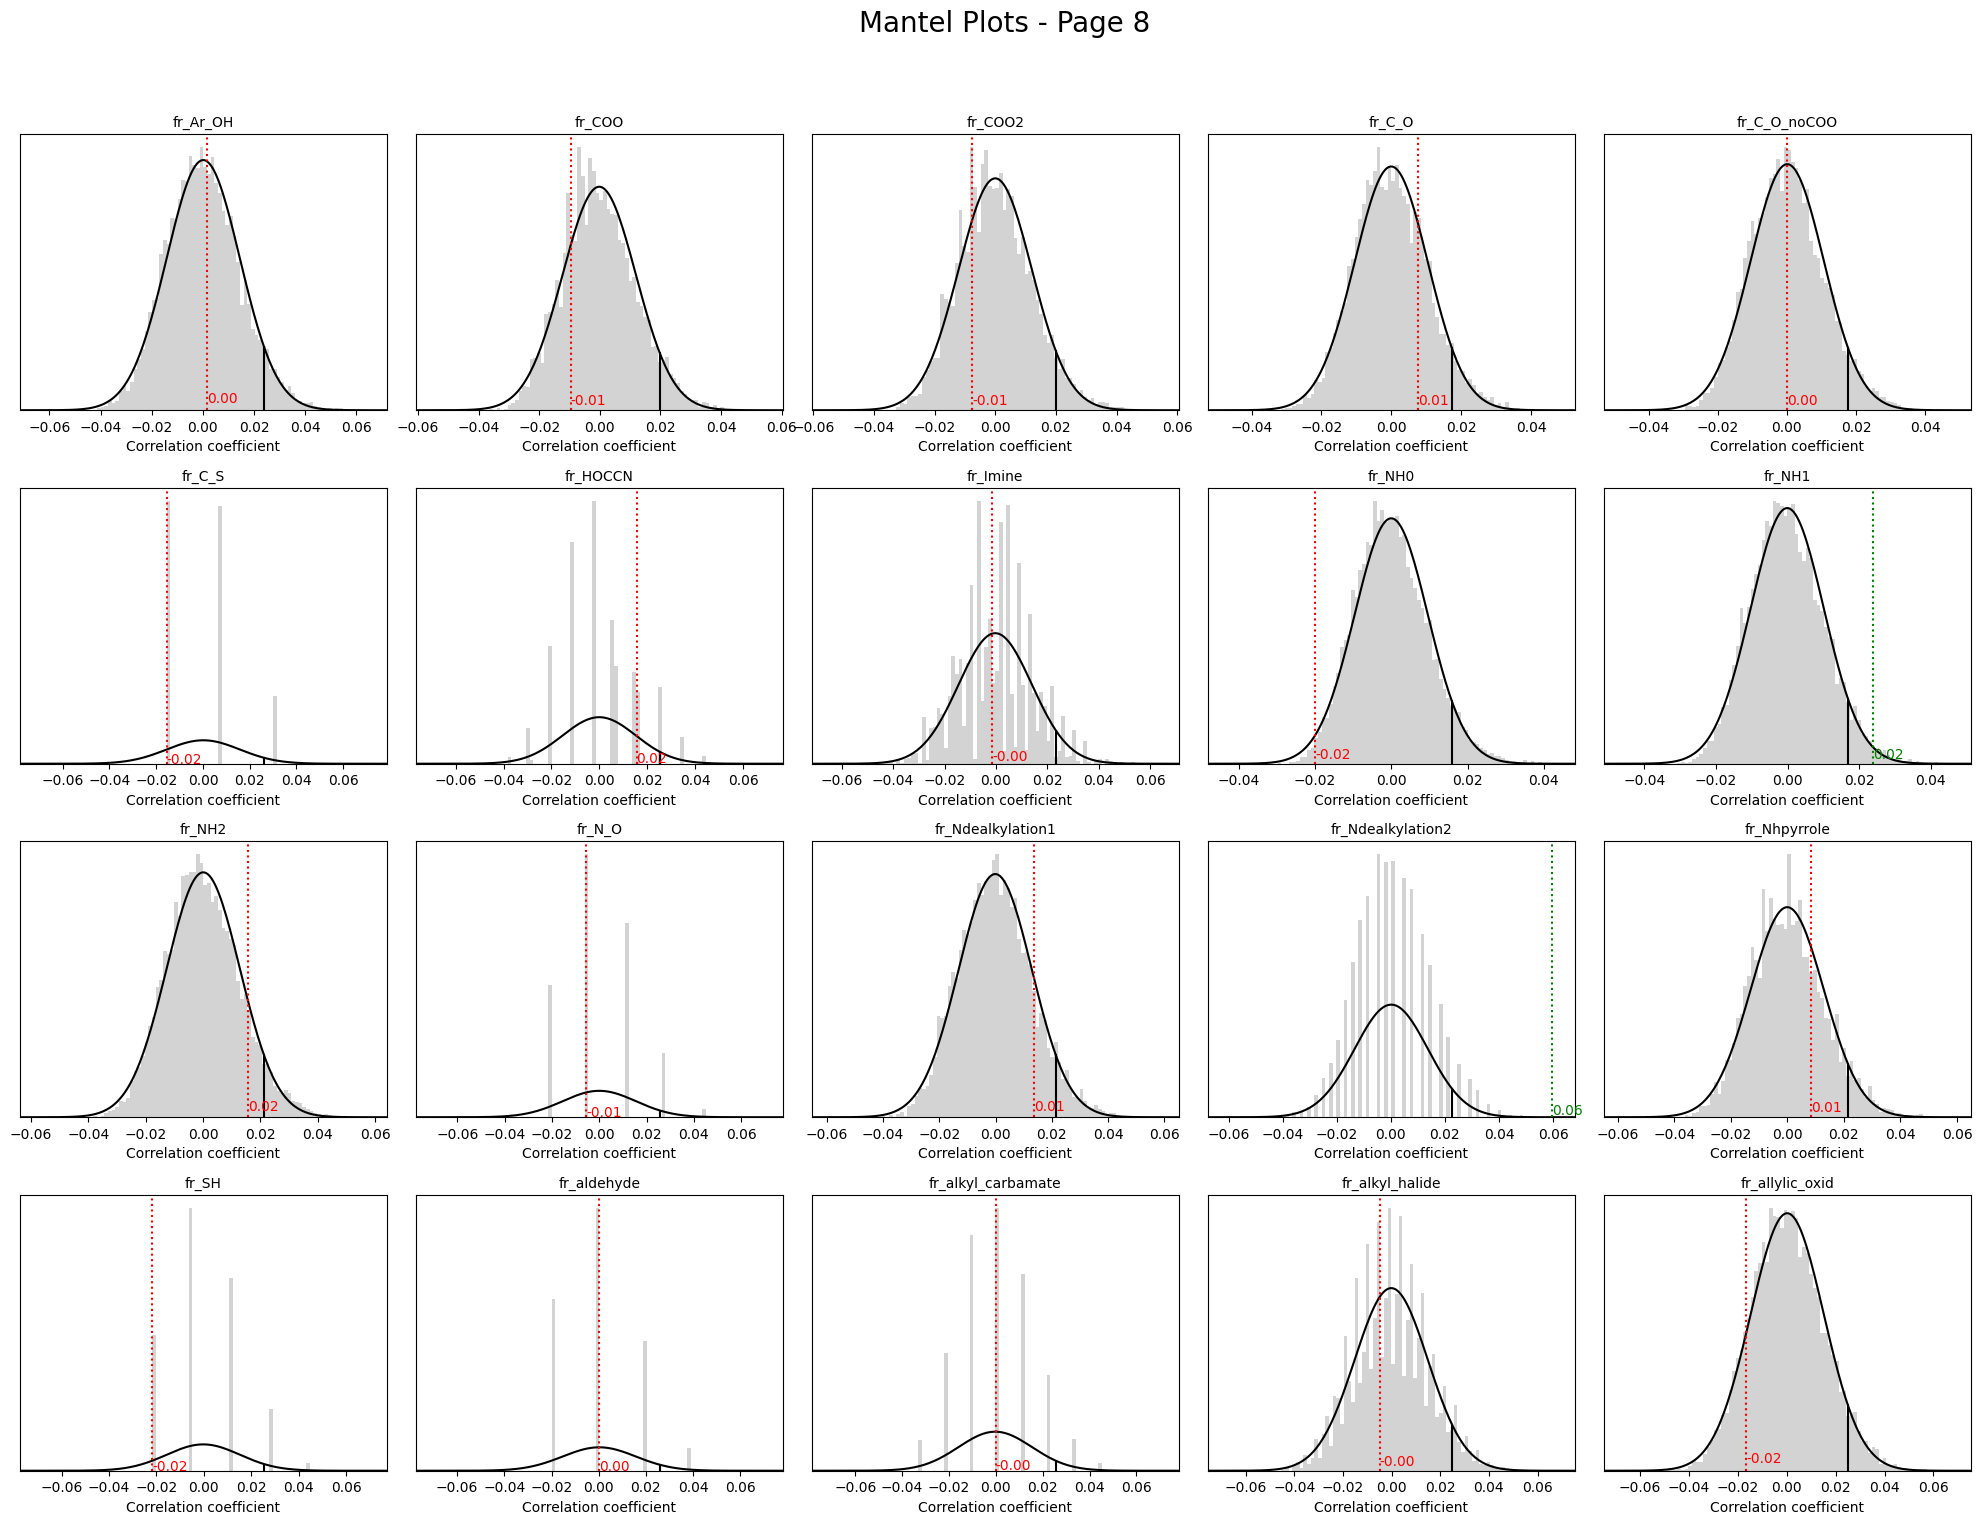

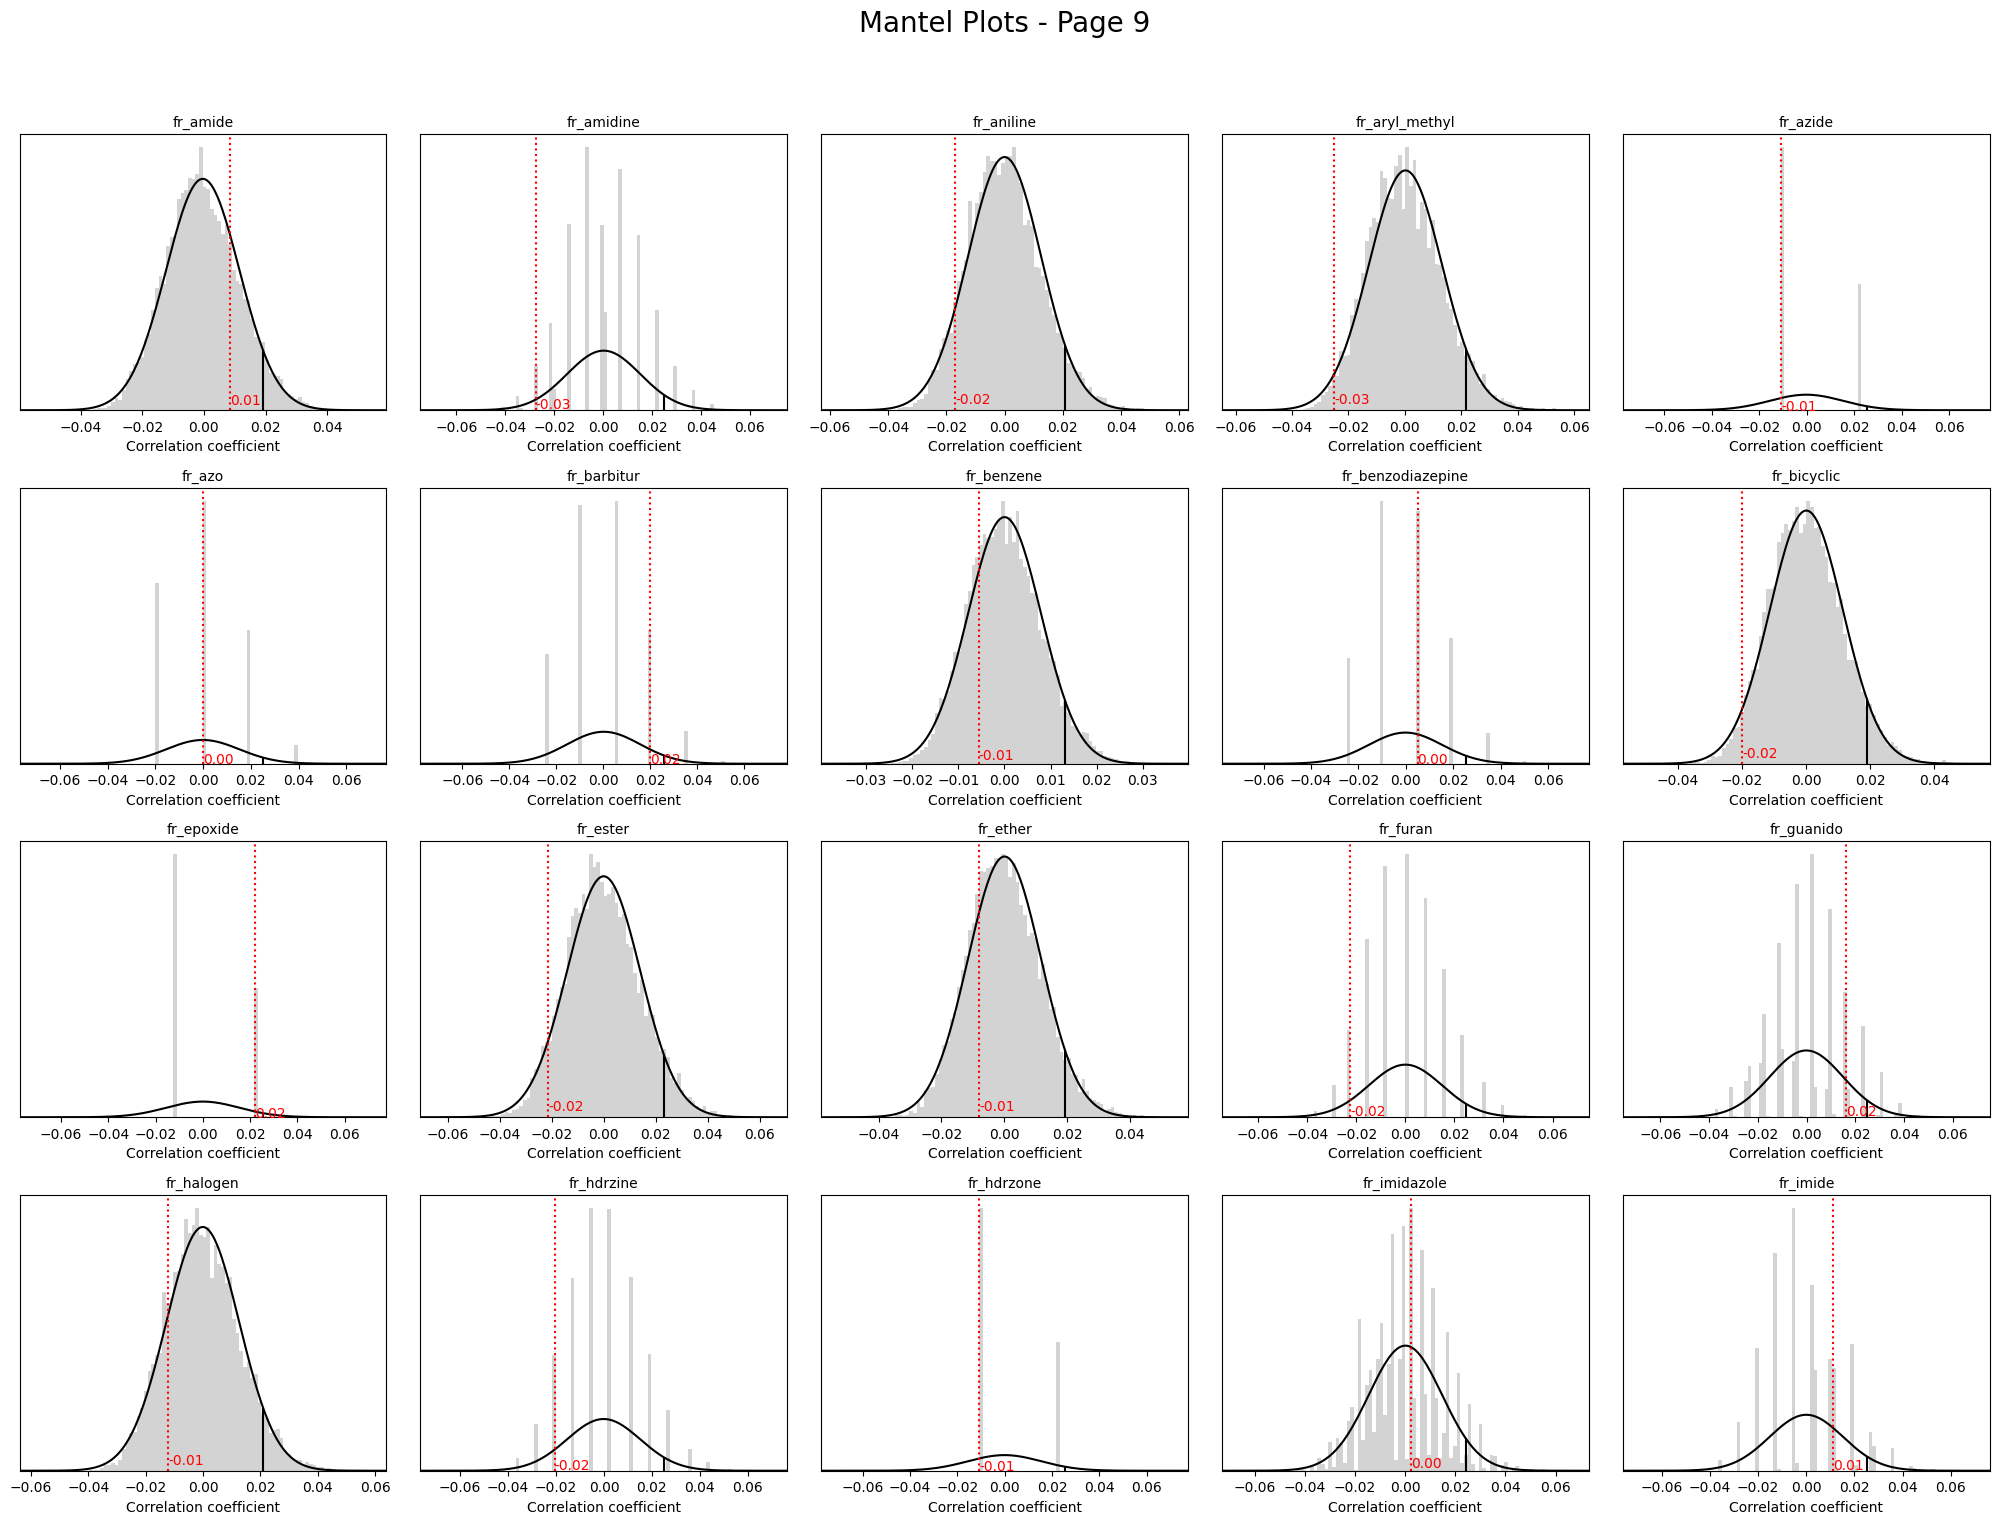

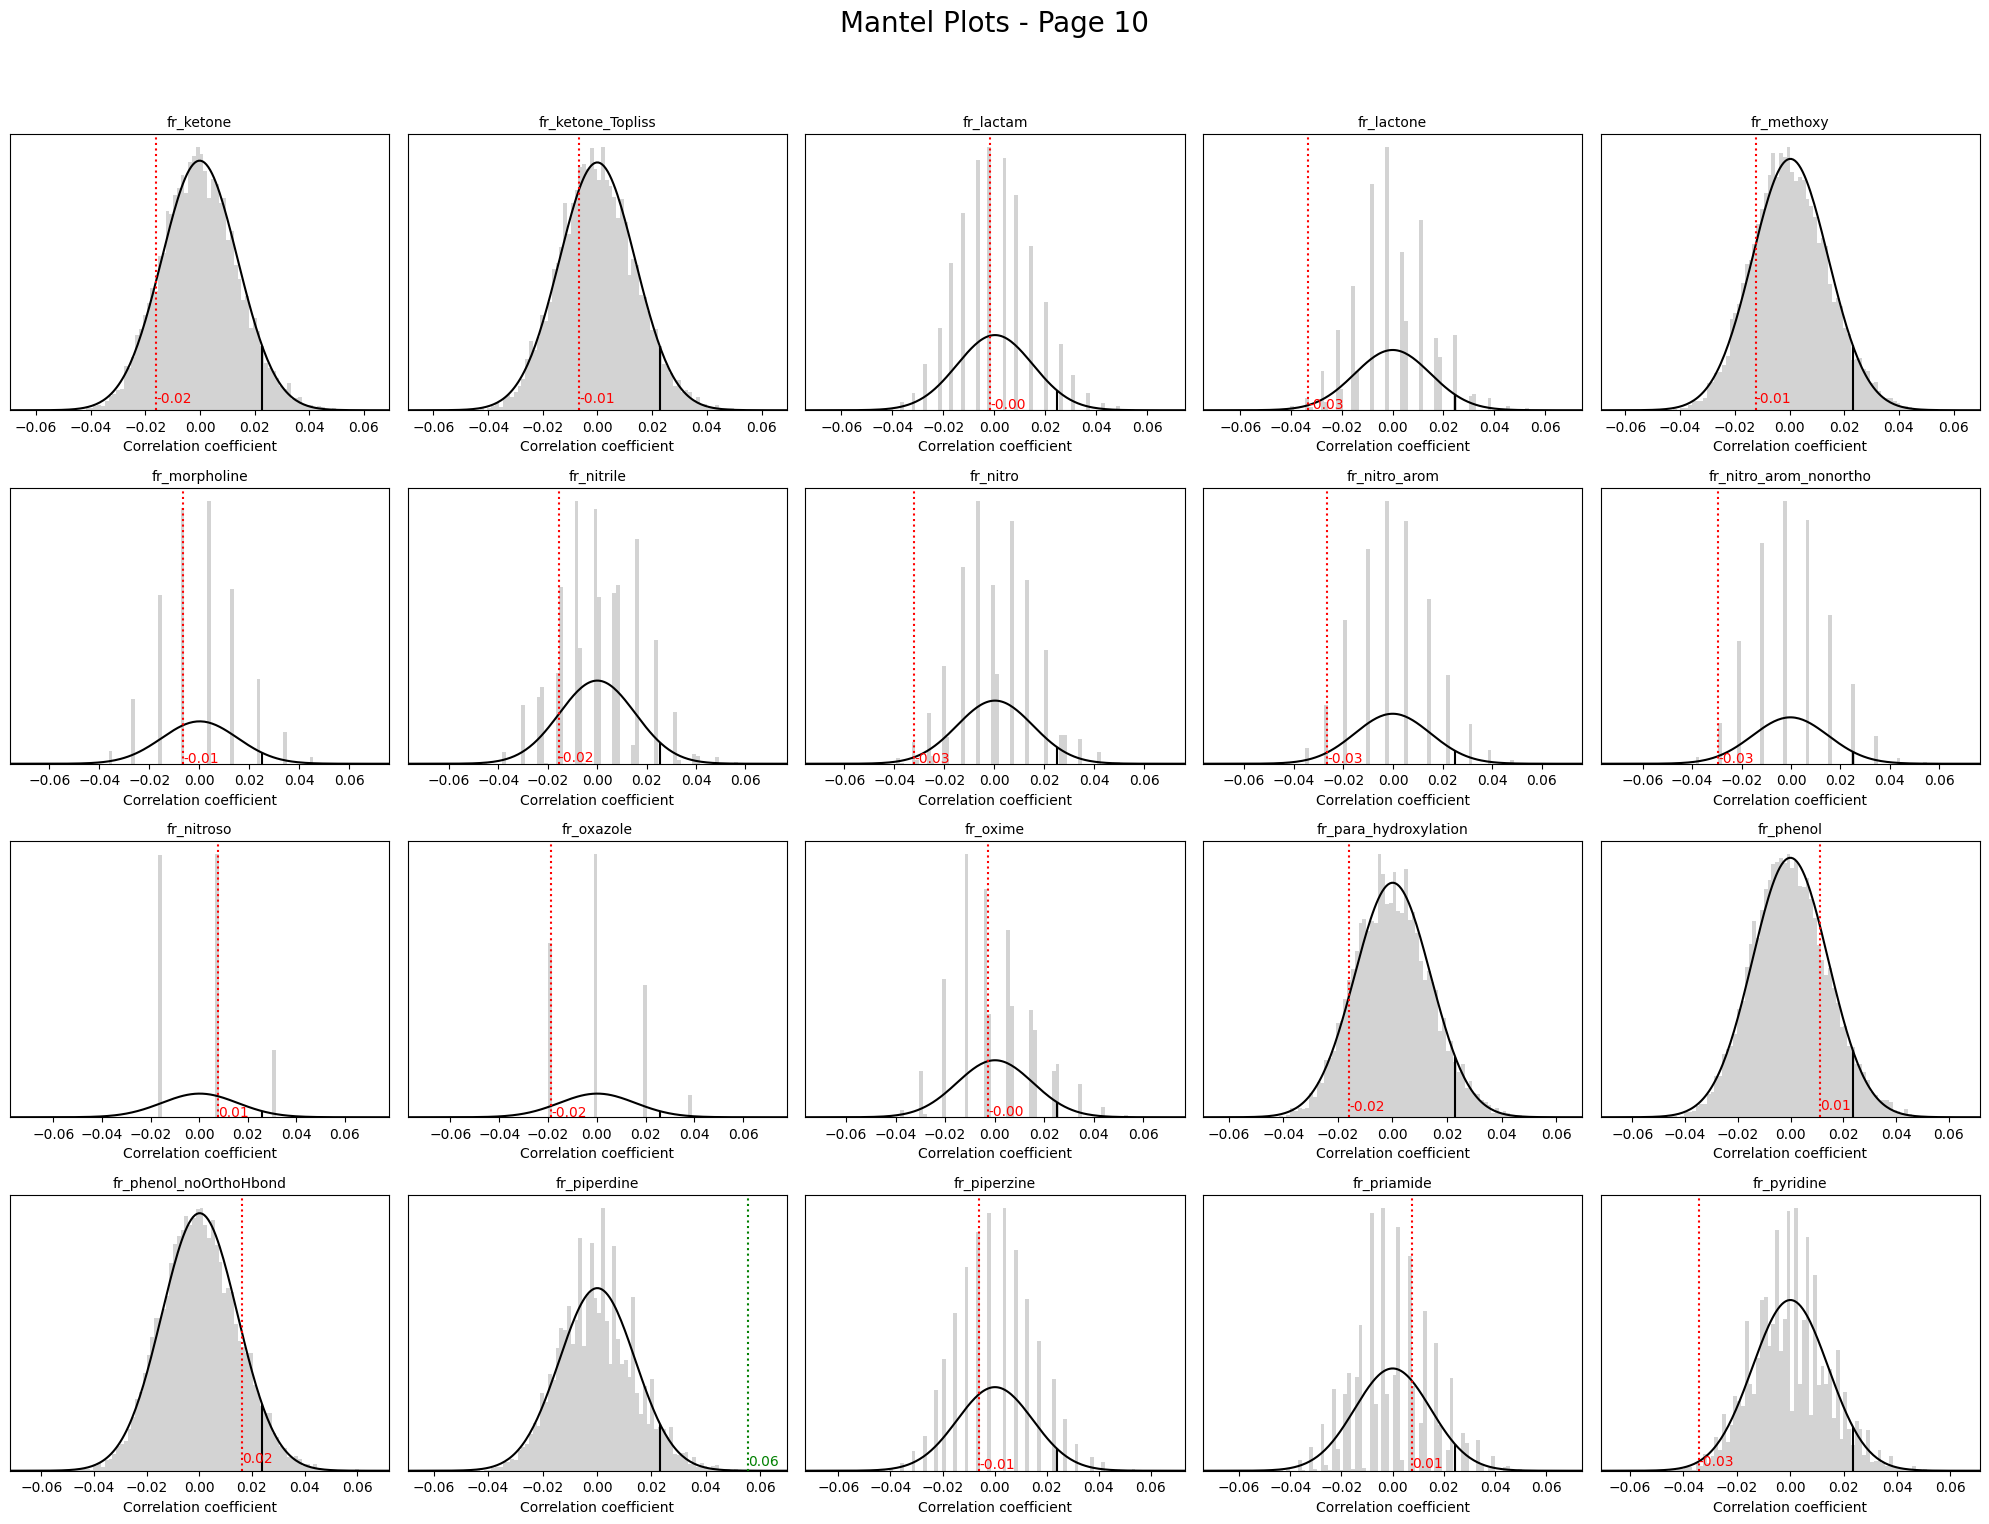

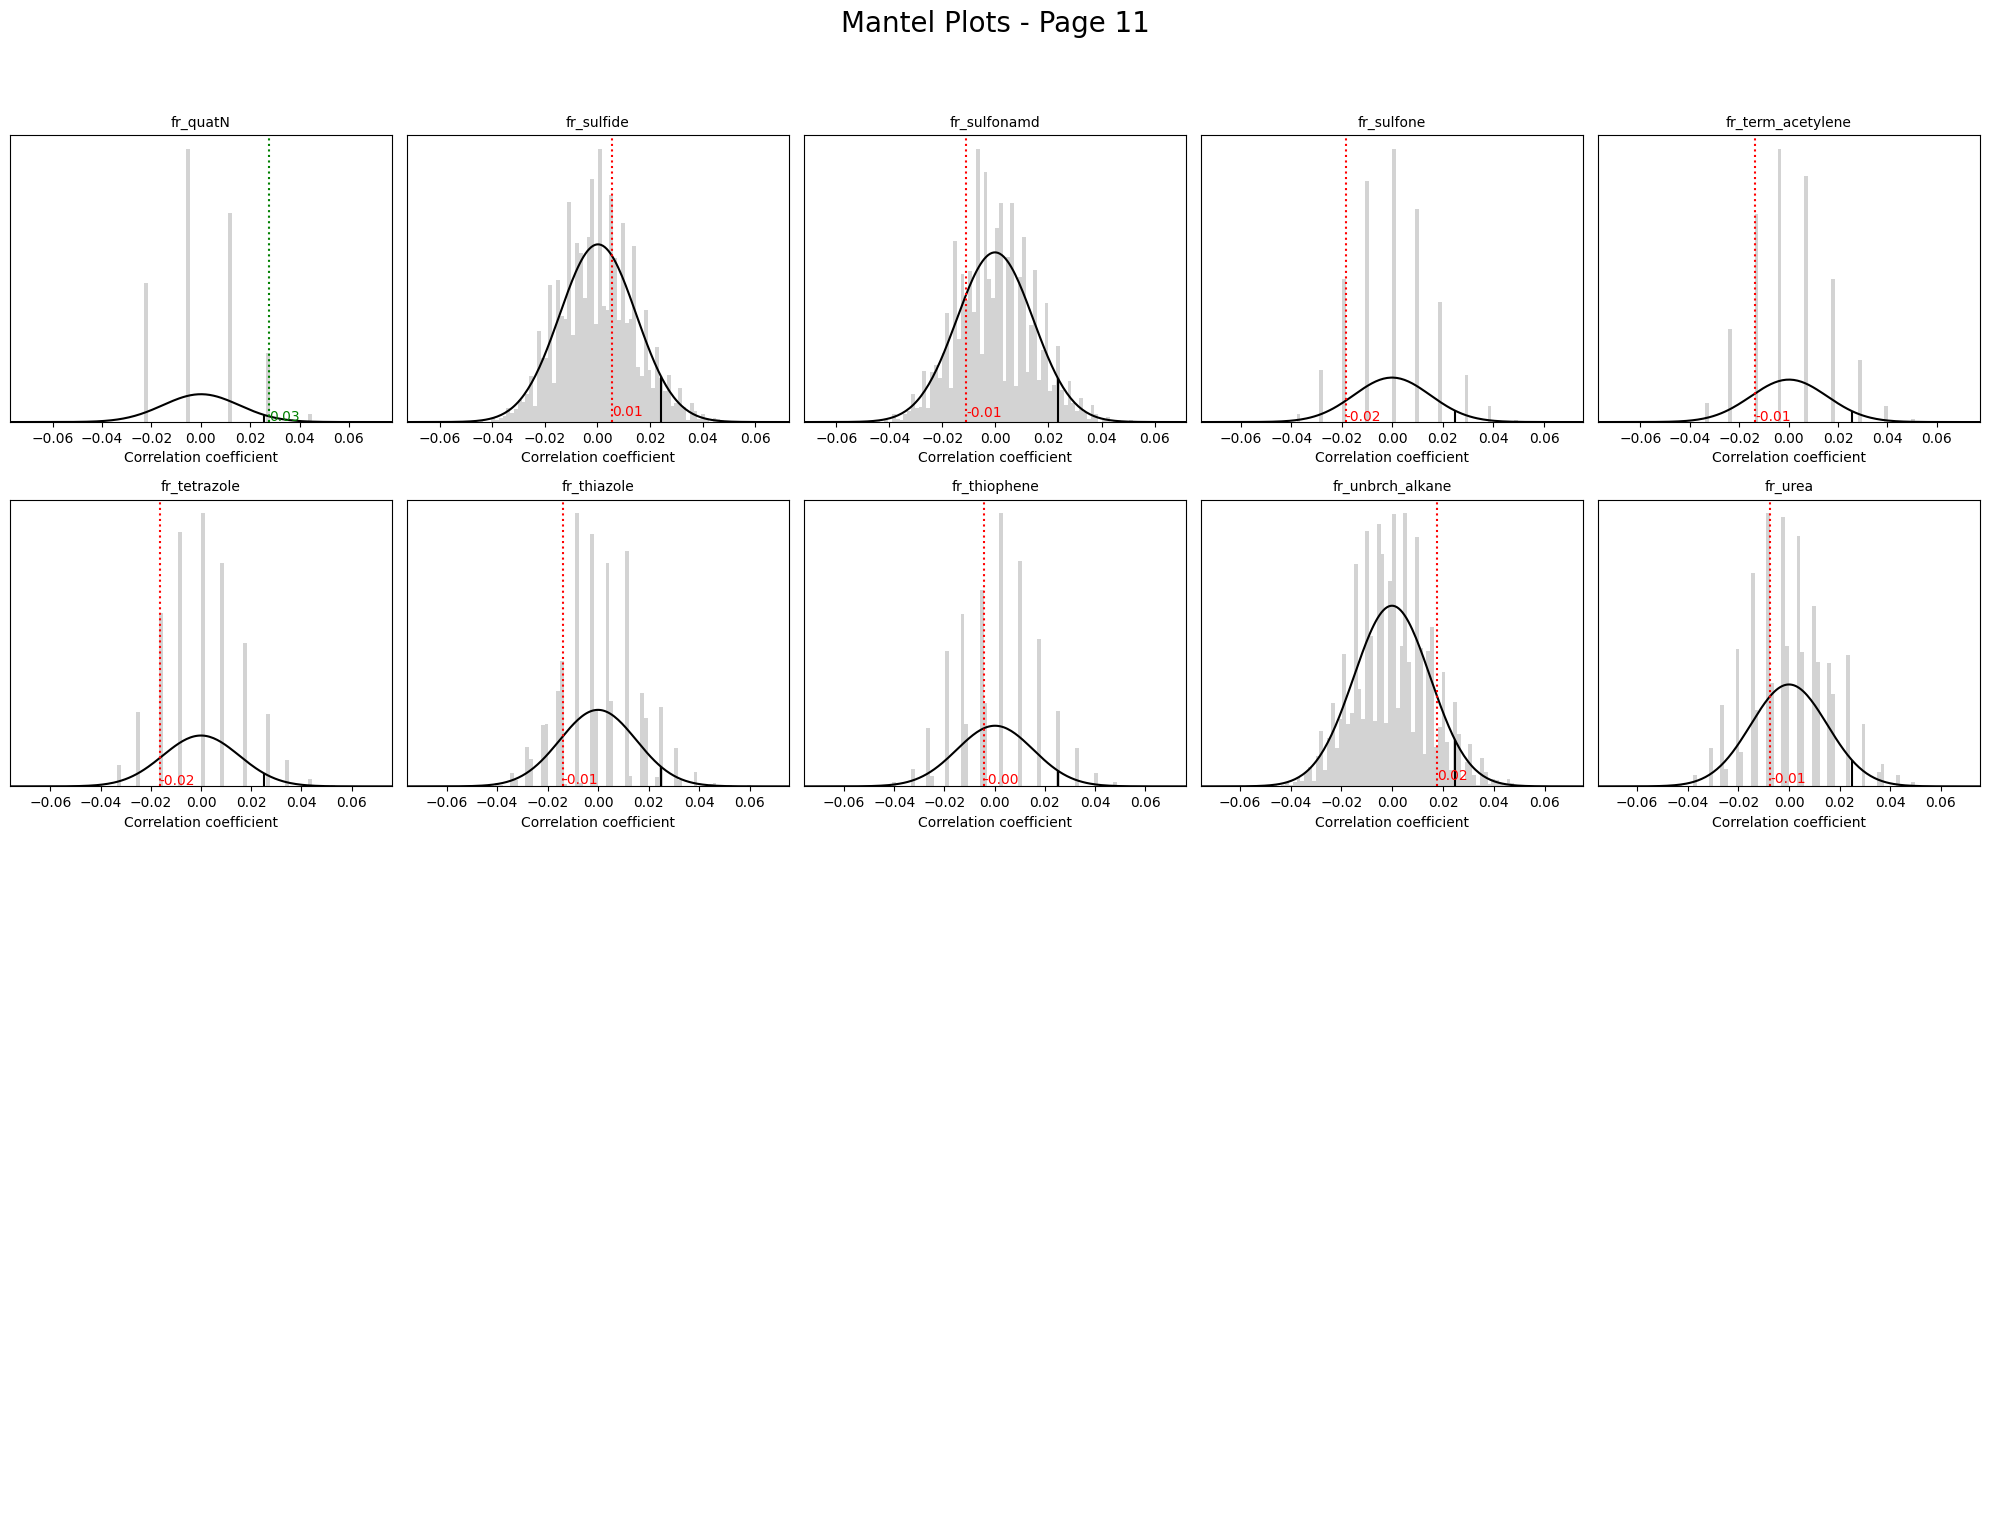

In [38]:
items = list(mantel_results.items())
total_items = len(items)
rows, cols = 4, 5
plots_per_figure = rows * cols
num_figures = math.ceil(total_items / plots_per_figure)

for i in range(num_figures):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    fig.suptitle(f'Mantel Plots - Page {i + 1}', fontsize=20)
    start_index = i * plots_per_figure
    end_index = min(start_index + plots_per_figure, total_items)
    current_items = items[start_index:end_index]
    for j, (key, value) in enumerate(current_items):
        ax = axes.flatten()[j]
        mantel.plot(value, axis=ax, acceptance_color='green', rejection_color='red')
        ax.set_title(key, fontsize=10)
    for j in range(len(current_items), plots_per_figure):
        axes.flatten()[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    output_filename = f'./mantel_plots/mantel_plots_page_{i + 1}.pdf'
    plt.savefig(output_filename)
    plt.show()
    plt.close(fig)

In [39]:
df_mantel_results.dropna(inplace=True)
mantel_features = df_mantel_results[df_mantel_results['p-value'] < 0.05].sort_values('Mantel r', ascending=False).index

In [40]:
mantel_features

Index(['fr_Ndealkylation2', 'fr_piperdine', 'fr_Al_OH', 'NumHDonors',
       'NHOHCount', 'NumBridgeheadAtoms', 'fr_Al_OH_noTert', 'MolLogP',
       'VSA_EState3', 'PEOE_VSA1', 'FpDensityMorgan3', 'MaxPartialCharge',
       'MinAbsPartialCharge', 'fr_quatN', 'AtomPairs', 'fr_NH1', 'fr_epoxide',
       'FpDensityMorgan2', 'fr_barbitur', 'SMR_VSA10', 'BalabanJ',
       'VSA_EState2', 'SlogP_VSA1', 'PEOE_VSA6'],
      dtype='object')

## Benchmark

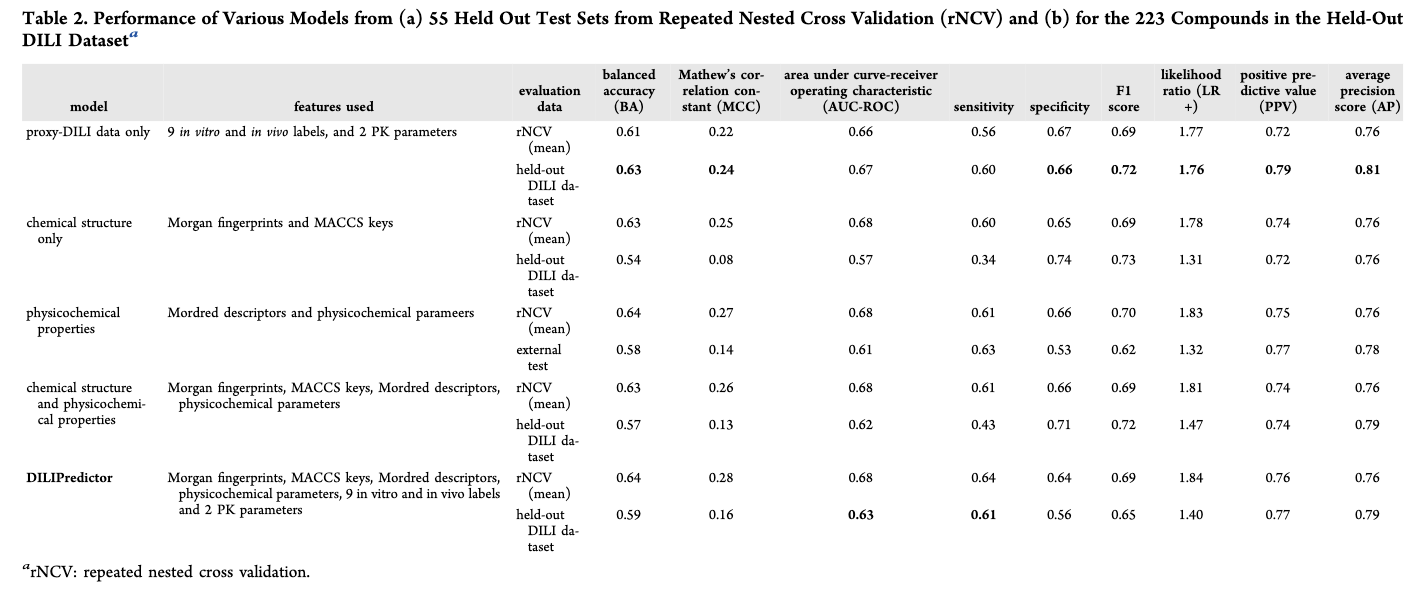

In [153]:
def process_fingerprints(df):
    other_features_df = df.drop(columns=['AtomPairs'])
    fp_array = np.array(list(df['AtomPairs']))
    fp_cols = [f'AP_{i}' for i in range(fp_array.shape[1])]
    fp_df = pd.DataFrame(fp_array, columns=fp_cols, index=df.index)
    final_df = pd.concat([other_features_df, fp_df], axis=1)
    return final_df

In [154]:
X_train = process_fingerprints(train_df[mantel_features])
y_train = train_df['TOXICITY']

In [155]:
X_test = process_fingerprints(test_df[mantel_features])
y_test = test_df['TOXICITY']

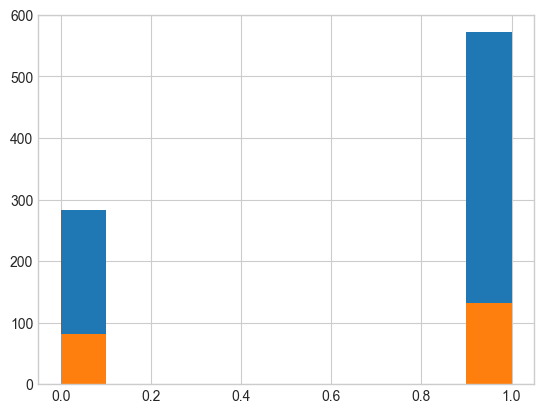

In [156]:
plt.hist(y_train)
plt.hist(y_test)
plt.show()

### Base Random Forest Classifier

In [157]:
rf_model = RandomForestClassifier()

In [158]:
N_SPLITS = 10
outer_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

In [159]:
results = []
roc_curves = []
pr_curves = []

for fold_idx, (train_idx, val_idx) in tqdm(enumerate(outer_cv.split(X_train, y_train)), total=10):
    X_train_outer, X_val_outer = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_outer, y_val_outer = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model.fit(X_train_outer, y_train_outer)
    y_pred = rf_model.predict(X_val_outer)
    y_proba = rf_model.predict_proba(X_val_outer)[:, 1]

    metrics = {
        'Fold': f'Fold {fold_idx + 1}',
        'Balanced Accuracy': balanced_accuracy_score(y_val_outer, y_pred),
        'Precision': precision_score(y_val_outer, y_pred, zero_division=0),
        'Recall': recall_score(y_val_outer, y_pred, zero_division=0),
        'F1-Score': f1_score(y_val_outer, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_val_outer, y_proba),
        'AUC-PR': average_precision_score(y_val_outer, y_proba),
        'Confusion Matrix': confusion_matrix(y_val_outer, y_pred)
    }
    results.append(metrics)
    fpr, tpr, _ = roc_curve(y_val_outer, y_proba)
    roc_curves.append((fpr, tpr, metrics['AUC-ROC']))    
    precision, recall, _ = precision_recall_curve(y_val_outer, y_proba)
    pr_curves.append((recall, precision, metrics['AUC-PR']))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.19it/s]


In [160]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [161]:
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

test_metrics = {
    'Fold': 'Hold-Out Test',
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, zero_division=0),
    'Recall': recall_score(y_test, y_test_pred, zero_division=0),
    'F1-Score': f1_score(y_test, y_test_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_test, y_test_proba),
    'AUC-PR': average_precision_score(y_test, y_test_proba),
    'Confusion Matrix': confusion_matrix(y_test, y_test_pred)
}
results.append(test_metrics)

### Random Forest Metrics

In [162]:
results_df = pd.DataFrame(results).set_index('Fold')
results_df.drop(columns=['Confusion Matrix'])

Balanced Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
Fold                                                                        
Fold 1                  0.551119   0.688312  0.929825  0.791045  0.673019   
Fold 2                  0.576528   0.704225  0.877193  0.781250  0.658500   
Fold 3                  0.585602   0.706667  0.929825  0.803030  0.592559   
Fold 4                  0.599754   0.726027  0.913793  0.809160  0.643165   
Fold 5                  0.546798   0.698630  0.879310  0.778626  0.662254   
Fold 6                  0.608083   0.728571  0.894737  0.803150  0.663221   
Fold 7                  0.589912   0.716216  0.929825  0.809160  0.667293   
Fold 8                  0.545113   0.692308  0.947368  0.800000  0.716792   
Fold 9                  0.563283   0.702703  0.912281  0.793893  0.678885   
Fold 10                 0.608083   0.728571  0.894737  0.803150  0.612155   
Hold-Out Test           0.550628   0.644809  0.893939  0.749206  0.631329   

                 AUC-PR  
Fold                     
Fold 1         0.791773  
Fold 2         0.795573  
Fold 3         0.707976  
Fold 4         0.776563  
Fold 5         0.801587  
Fold 6         0.820737  
Fold 7         0.788020  
Fold 8         0.815553  
Fold 9         0.804497  
Fold 10        0.716027  
Hold-Out Test  0.727798

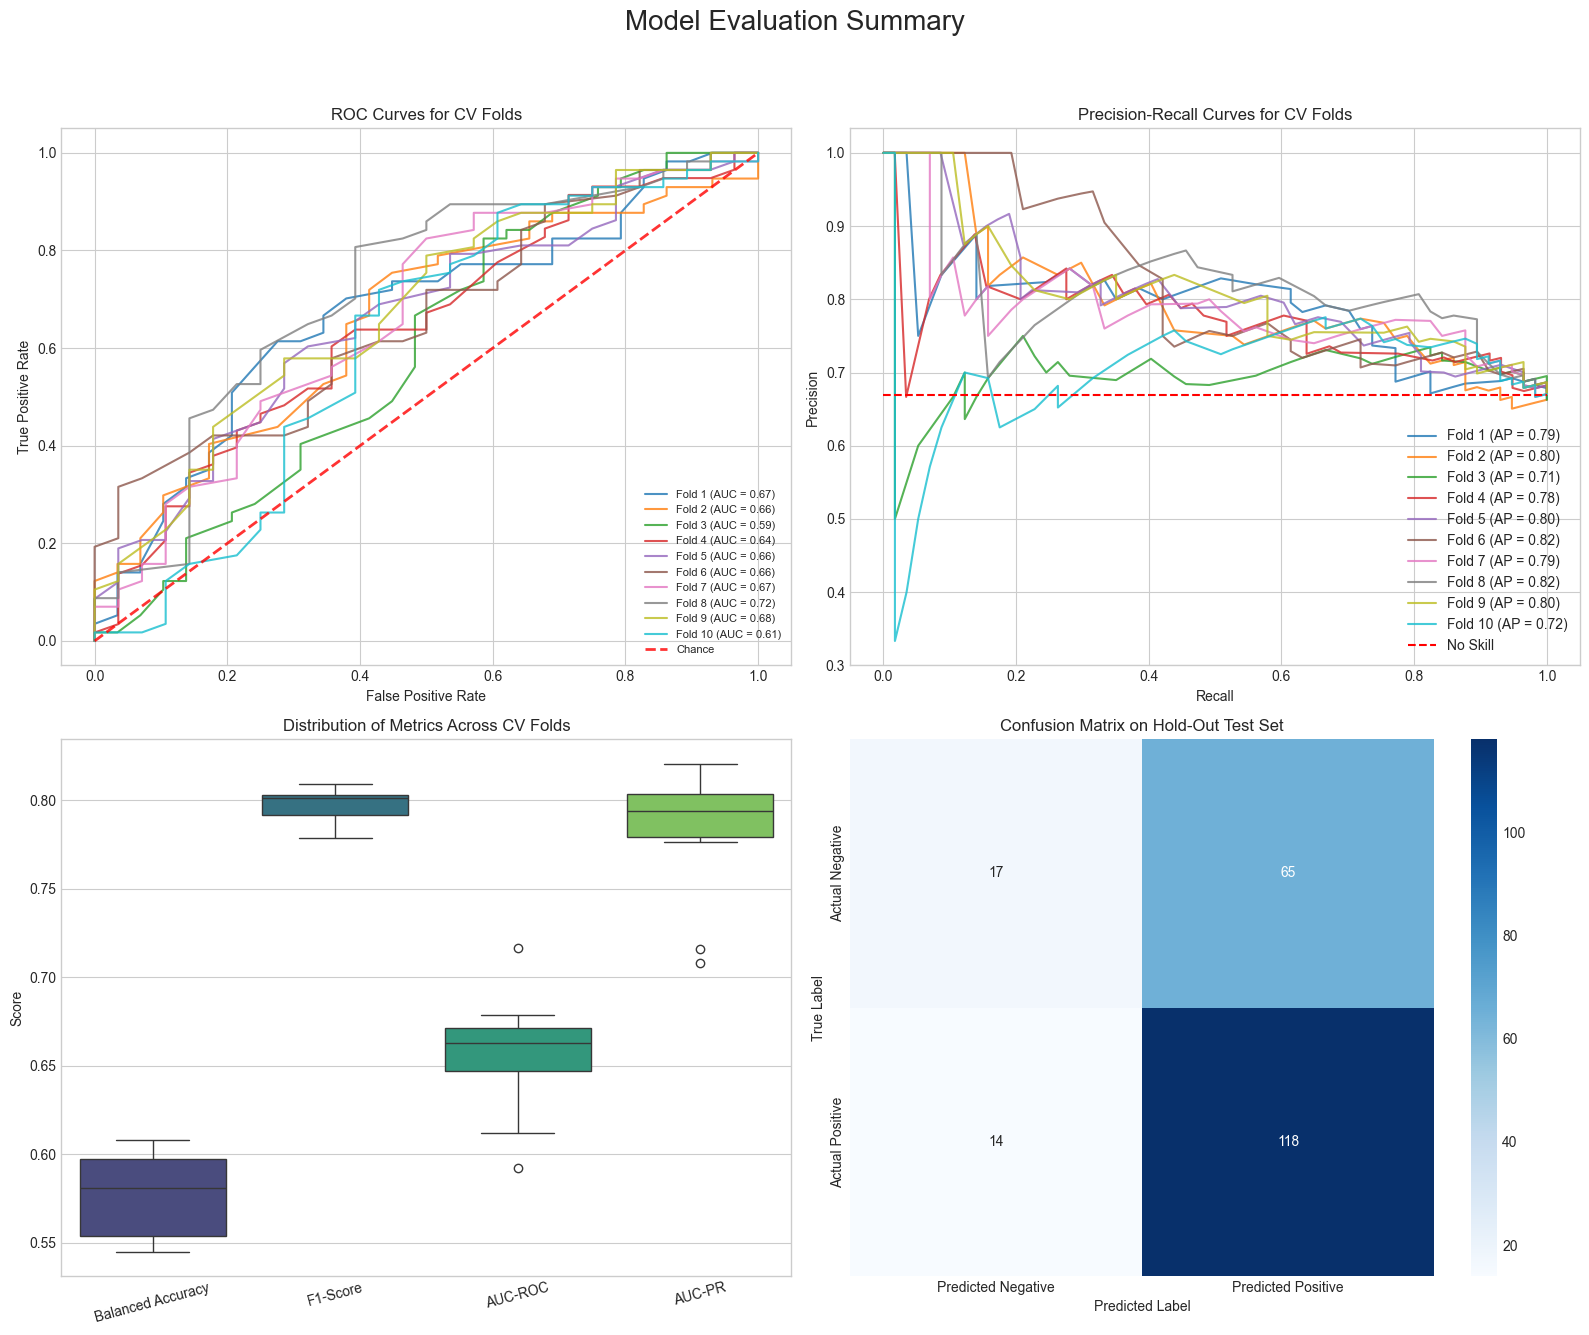

In [163]:
def report_results(roc_curves, pr_curves, results_df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Model Evaluation Summary', fontsize=20)
    plt.style.use('seaborn-v0_8-whitegrid')
    
    ax1 = axes[0, 0]
    for i, (fpr, tpr, auc) in enumerate(roc_curves):
        ax1.plot(fpr, tpr, lw=1.5, alpha=0.8, label=f'Fold {i+1} (AUC = {auc:.2f})')
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           xlabel="False Positive Rate", ylabel="True Positive Rate",
           title="ROC Curves for CV Folds")
    ax1.legend(loc="lower right", fontsize=8)
    ax1.grid(True)
    
    ax2 = axes[0, 1]
    for i, (recall, precision, avg_prec) in enumerate(pr_curves):
        ax2.plot(recall, precision, lw=1.5, alpha=0.8, label=f'Fold {i+1} (AP = {avg_prec:.2f})')
    no_skill = len(y_train[y_train==1]) / len(y_train)
    ax2.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
    ax2.set(xlabel='Recall', ylabel='Precision', title='Precision-Recall Curves for CV Folds')
    ax2.legend()
    ax2.grid(True)
    
    metrics_to_plot = ['Balanced Accuracy', 'F1-Score', 'AUC-ROC', 'AUC-PR']
    plot_data = results_df.loc[results_df.index != 'Hold-Out Test', metrics_to_plot]
    ax3 = axes[1, 0]
    sns.boxplot(data=plot_data, ax=ax3, palette='viridis')
    ax3.set_title('Distribution of Metrics Across CV Folds')
    ax3.set_ylabel('Score')
    ax3.tick_params(axis='x', rotation=15)
    
    ax4 = axes[1, 1]
    cm = test_metrics['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    ax4.set_title('Confusion Matrix on Hold-Out Test Set')
    ax4.set_ylabel('True Label')
    ax4.set_xlabel('Predicted Label')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

report_results(roc_curves, pr_curves, results_df)

# Train on all Data

In [186]:
def featurize(df, smiles_col):
    df['ECFP4'] = df[smiles_col].apply(lambda m: ecfp4gen.GetFingerprint(Chem.MolFromSmiles(m)))
    df['AtomPairs'] = df[smiles_col].apply(lambda m: atomgen.GetFingerprint(Chem.MolFromSmiles(m)))
    df['MACCS'] = df[smiles_col].apply(lambda m: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(m)))
    df = df.join(pd.DataFrame([Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(s)) for s in df[smiles_col]], index=df.index))
    df = df[mantel_features]
    df = process_fingerprints(df)
    return df

In [187]:
rf_model_all = RandomForestClassifier(random_state=42)

In [188]:
X_all = process_fingerprints(df[mantel_features])
y_all = df['TOXICITY']
rf_model_all.fit(X_all, y_all)

RandomForestClassifier(random_state=42)

# DILIPredictor 4 Held Out Compounds Test

In [189]:
four_compounds = pd.DataFrame(columns=['name','smiles', 'tox'])

In [190]:
four_compounds['name'] = ['2-Butoxyethanol', 'Astaxanthin', 'Enzalutamide', 'Sitaxentan']

four_compounds['smiles'] = ['CCCCOCCO',
 'CC(C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1C(C)C(=O)C(=O)CC1(C)C',
 'CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C2(C)C)cc1F',
 'Cc1cc2c(cc1CC(=O)c1sccc1S(=O)(=O)N=c1o[nH]c(C)c1Cl)OCO2']

four_compounds['tox'] = [0, 0, 1, 1]

In [191]:
four_compounds_test = featurize(four_compounds, 'smiles')
four_compounds_test 

fr_Ndealkylation2  fr_piperdine  fr_Al_OH  NumHDonors  NHOHCount  \
0                  0             0         1           1          1   
1                  0             0         0           0          0   
2                  0             0         0           1          1   
3                  0             0         0           1          1   

   NumBridgeheadAtoms  fr_Al_OH_noTert  MolLogP  VSA_EState3  PEOE_VSA1  ...  \
0                   0                1  0.79540     8.240587   9.843390  ...   
1                   0                0  9.19340     0.000000   0.000000  ...   
2                   0                0  3.99248    11.119541  10.216698  ...   
3                   0                0  3.38314     4.043622  13.996821  ...   

   AP_2038  AP_2039  AP_2040  AP_2041  AP_2042  AP_2043  AP_2044  AP_2045  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        1        1        0        0        0        0   
3        0        0        0        0        0        0        0        0   

   AP_2046  AP_2047  
0        0        0  
1        0        0  
2        0        0  
3        0        0  

[4 rows x 2071 columns]

### RF Predictions

In [192]:
rf_model_all.predict(four_compounds_test)

array([1, 1, 1, 1])

DILIPred Successfully Predicts for All 4 Compounds.

N.B. **High recall** for tox prediction is quite OK !

# HELD OUT TOX TEST 
Courtesy of Srijit Seal

In [193]:
heldout_test = pd.read_csv("./Combined_DILI_Labels__preview_.csv")

In [194]:
def get_smiles(drug_name):
    encoded_name = quote(drug_name)
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{encoded_name}/property/SMILES/TXT"
    try:
        response = requests.get(url)
        time.sleep(0.2) 
        
        if response.status_code == 200:
            return response.text.strip()
        else:
            return None 
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [195]:
if not os.path.exists("./srijit_held_out_pubchem.csv"):
    heldout_test['pubchem_smiles'] = heldout_test['Compound'].apply(get_smiles)
    heldout_test.to_csv('srijit_held_out_pubchem.csv', index=False)
else:
    heldout_test = pd.read_csv('srijit_held_out_pubchem.csv')

In [196]:
heldout_test.dropna(subset=['pubchem_smiles'], inplace=True)

In [197]:
heldout_test.shape

(48, 13)

In [198]:
heldout_test["standardized_smiles"] = heldout_test["pubchem_smiles"].apply(standardize_smiles)
heldout_test.dropna(subset=["standardized_smiles"], inplace=True)
heldout_test.drop_duplicates(subset=["standardized_smiles"], inplace=True)

In [199]:
heldout_test.shape

(44, 14)

### Check for Same Compounds in Training data

In [200]:
count = 0
for i in heldout_test['standardized_smiles'].values:
    if i in set(df['standardized_smiles'].values):
        print(i)
        count = count + 1

CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1


In [201]:
heldout_test = heldout_test[heldout_test['standardized_smiles'] != 'CCCN(CCC)S(=O)(=O)c1ccc(C(=O)O)cc1']

In [202]:
def report_results(y_true, y_pred_label, y_pred_proba):  
    accuracy = accuracy_score(y_true, y_pred_label)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    mcc = matthews_corrcoef(y_true, y_pred_label)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
    auc_pr = auc(recall_vals, precision_vals)
    cm = confusion_matrix(y_true, y_pred_label)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
        
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    cm = confusion_matrix(y_true, y_pred_label)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'], ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc="lower right")
    axes[1].grid(True)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])

    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
    auc_pr = auc(recall_vals, precision_vals)
    axes[2].plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (area = {auc_pr:.2f})')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend(loc="lower left")
    axes[2].grid(True)
    
    plt.tight_layout()

### Held Out Test Set Performance Comparison against DILIPred

In [211]:
X_heldout_test_feat = featurize(heldout_test, 'standardized_smiles')
y_heldout_test = heldout_test['DILI_labels']

## DILIPredictor Performance 

In [212]:
# From pip install dilipred
dilipred_y_pred = np.array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1])
dilipred_y_proba = np.array([0.5595301537432864, 0.6818318985310486, 0.7183581971520153, 0.7074544976403891, 0.5727708361206374, 0.7881453486296197, 0.7244132642336356, 0.7065890698469104, 0.7490502280121918, 0.7550958451708347, 0.7253758927770828, 0.705614649588674, 0.6441973615005281, 0.77508837269182, 0.7529056875947782, 0.7946787061857092, 0.7700665301263164, 0.7827429289697462, 0.7916378867548803, 0.5347777493787989, 0.7959886307351588, 0.7735855154981586, 0.7820979395275052, 0.7177515921685295, 0.591343271844951, 0.6868624926178205, 0.7356512411728747, 0.6713961849510875, 0.6321221155175213, 0.7707921590171392, 0.6222934633402368, 0.6682948795042682, 0.7415779772667775, 0.6885630763398819, 0.5336041843528422, 0.7429022632812332, 0.6485557014257974, 0.5648311144835788, 0.44196193178186455, 0.7272185141904527, 0.6817274931314908, 0.6953123147656514, 0.6304839740112527])

AUC from TPR curves: 0.649
TPR Envelope AUC range: (0.406, 0.869)
TPR Envelope AUC range is not the statistical confidence interval, it's just the area under the lower/upper percentile ROC curves.


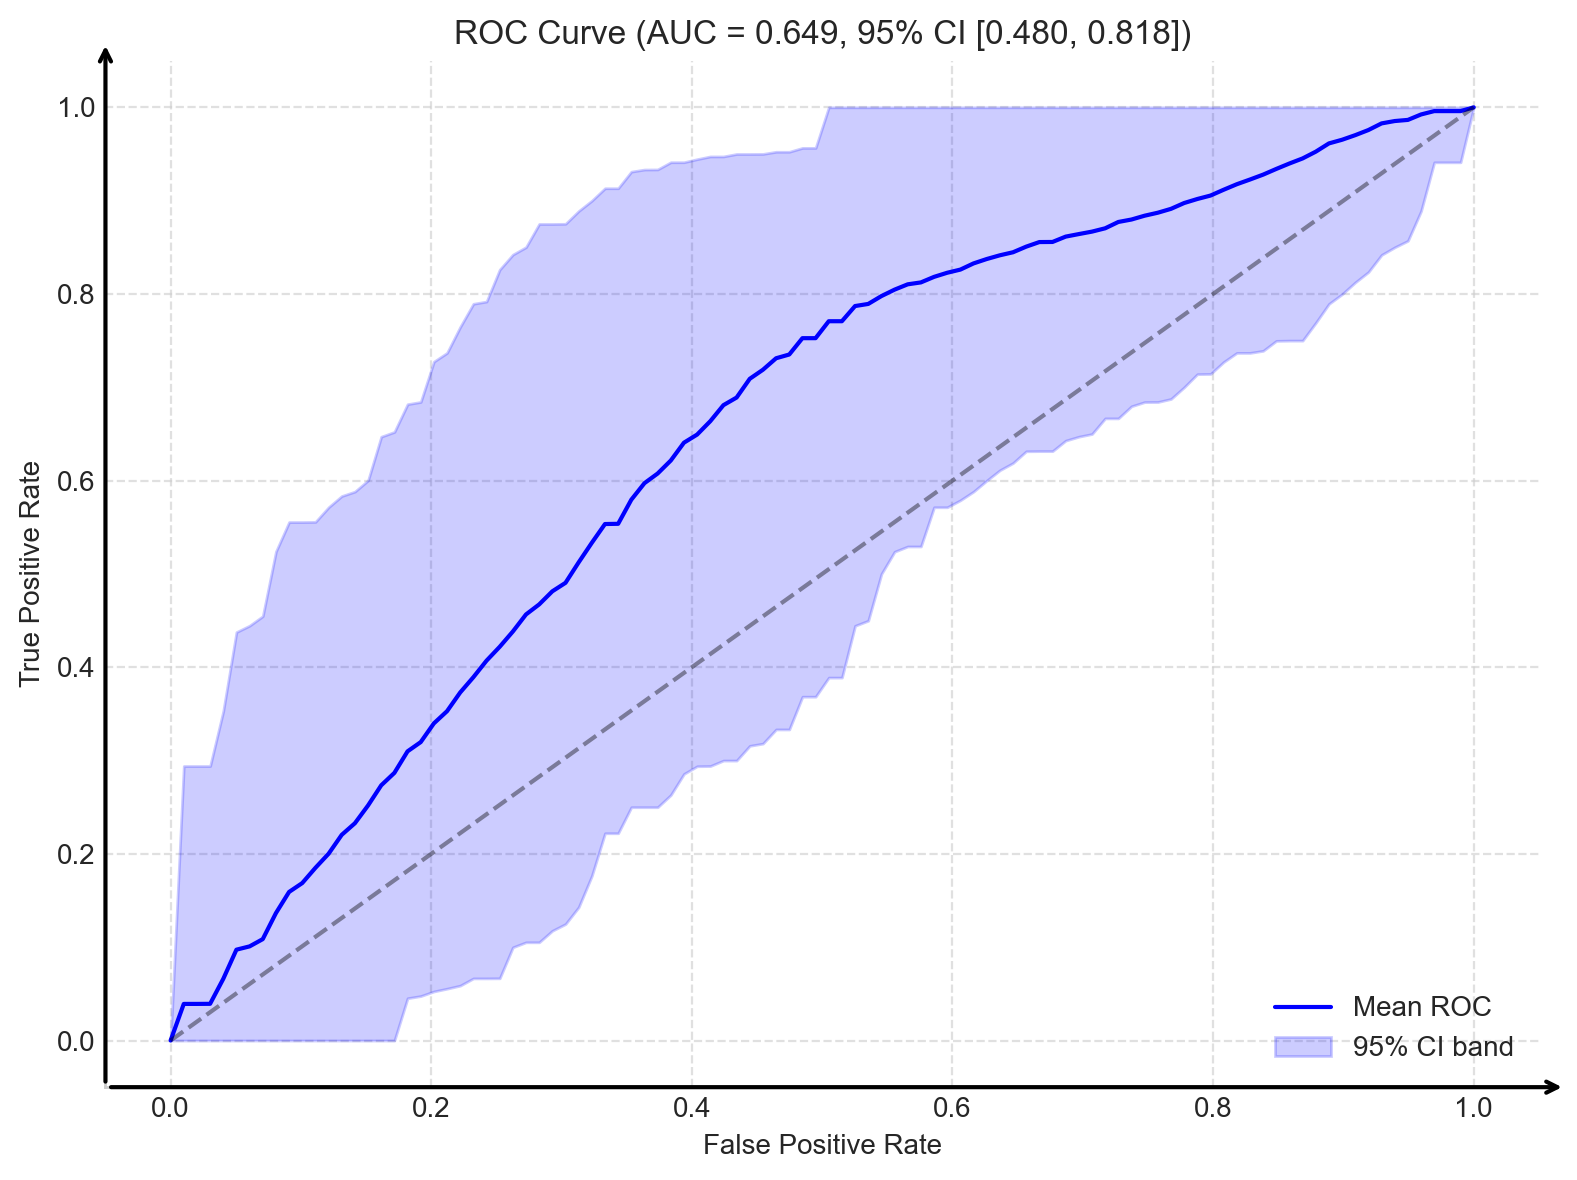

Accuracy: 0.4884
Balanced Accuracy: 0.5444
Precision: 0.4444
Recall: 0.8889
Matthews Correlation Coefficient (MCC): 0.1188
AUC-ROC: 0.6489
AUC-PR: 0.4999


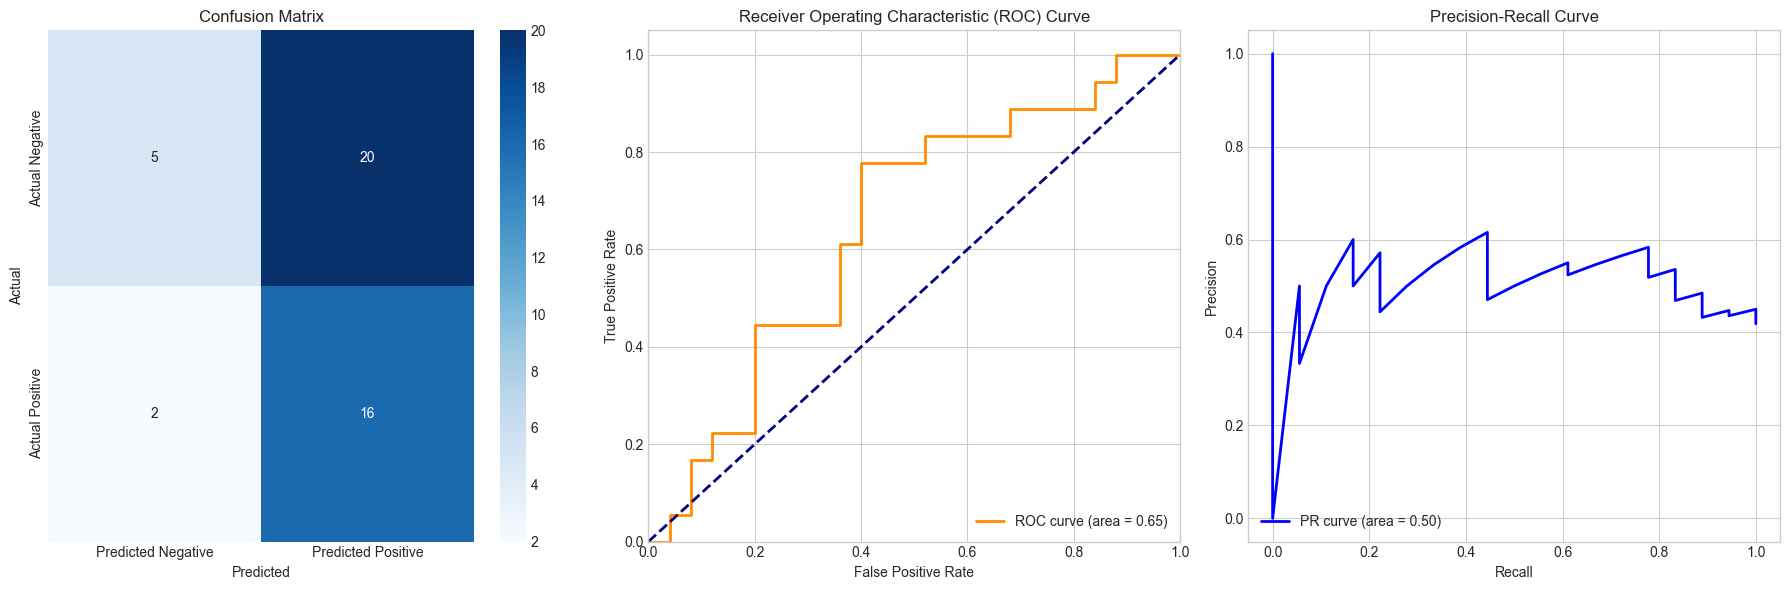

In [214]:
plot_roc_with_ci(y_heldout_test.values, dilipred_y_proba)
report_results(y_heldout_test, dilipred_y_pred, dilipred_y_proba)

## MantelRank Model

In [215]:
y_rf_all_pred = rf_model_all.predict(X_heldout_test_feat)
y_rf_all_pred_proba = rf_model_all.predict_proba(X_heldout_test_feat)[:, 1]

AUC from TPR curves: 0.572
TPR Envelope AUC range: (0.332, 0.793)
TPR Envelope AUC range is not the statistical confidence interval, it's just the area under the lower/upper percentile ROC curves.


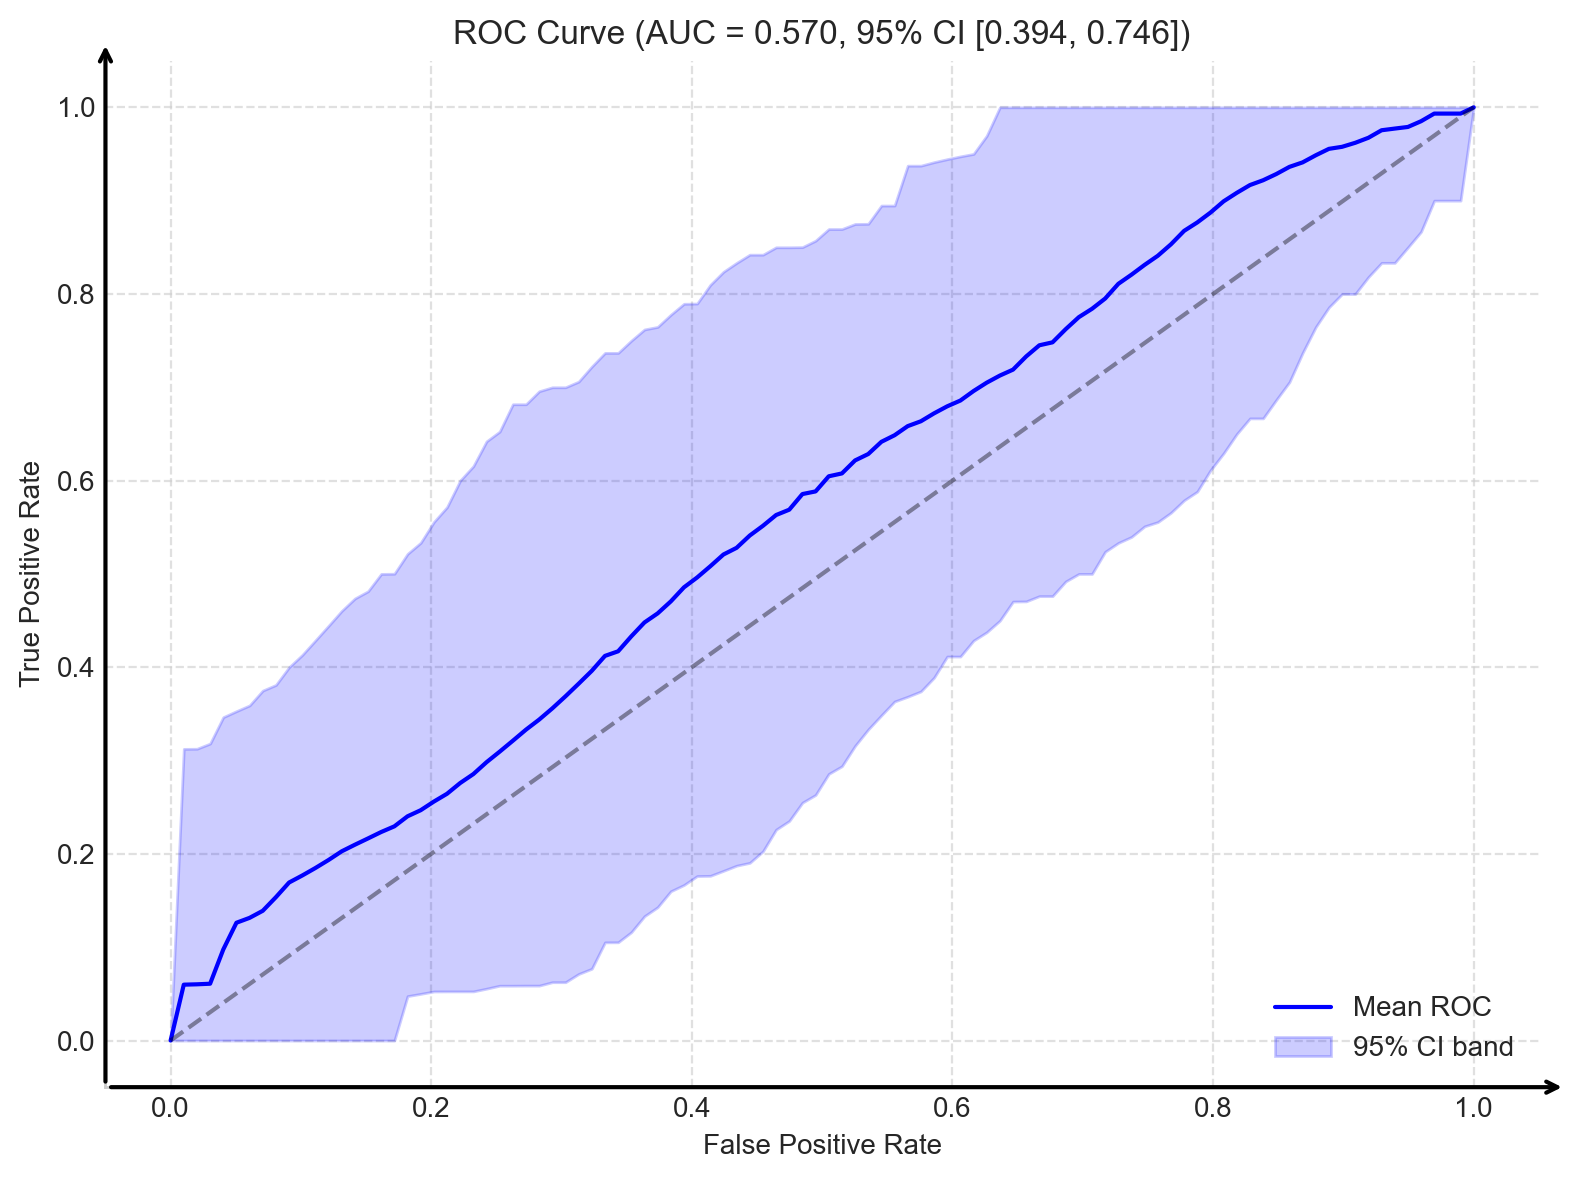

Accuracy: 0.4651
Balanced Accuracy: 0.5400
Precision: 0.4390
Recall: 1.0000
Matthews Correlation Coefficient (MCC): 0.1874
AUC-ROC: 0.5700
AUC-PR: 0.4623


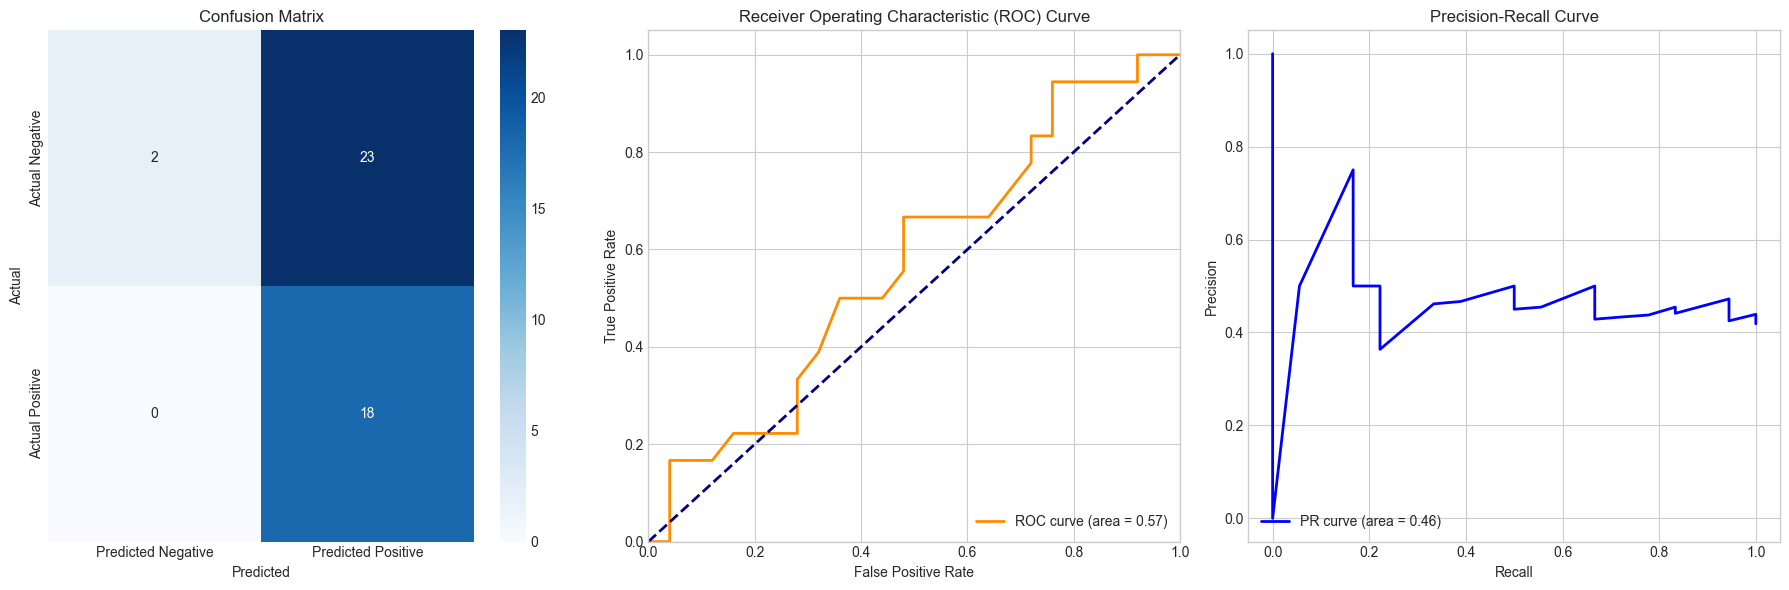

In [217]:
plot_roc_with_ci(y_heldout_test.values, y_rf_all_pred_proba)
report_results(y_heldout_test, y_rf_all_pred, y_rf_all_pred_proba)

## DeLong’s test

In [218]:
log_pval = delong_roc_test(heldout_test['DILI_labels'], y_rf_all_pred_proba, dilipred_y_proba)
p_value = 10 ** log_pval
print(f"DeLong’s test p-value: {p_value}")

DeLong’s test p-value: 0.3570185264720781


In [246]:
!tree .

.
├── Combined_DILI_Labels__preview_.csv
├── DILI_Goldstandard_1111_std.csv
├── DILI_Goldstandard_1111.csv
├── environment.yaml
├── mantel_plots
│   ├── mantel_plots_page_1.pdf
│   ├── mantel_plots_page_10.pdf
│   ├── mantel_plots_page_11.pdf
│   ├── mantel_plots_page_2.pdf
│   ├── mantel_plots_page_3.pdf
│   ├── mantel_plots_page_4.pdf
│   ├── mantel_plots_page_5.pdf
│   ├── mantel_plots_page_6.pdf
│   ├── mantel_plots_page_7.pdf
│   ├── mantel_plots_page_8.pdf
│   └── mantel_plots_page_9.pdf
├── mantel_results.csv
├── mantel_results.pickle
├── MantelRank.ipynb
├── srijit_held_out_pubchem.csv
├── test_df.pkl
└── train_df.pkl

1 directory, 21 files
